<a href="https://colab.research.google.com/github/bernardosluz/FloorPlan-Element-Detection/blob/main/notebooks/Deteccao_Planta_Baixa_Detalhado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dupla
- **Bernardo Silva Luz** — Matrícula: 202200092389
- **Madson Silva** — Matrícula: 201700063075

**Professor:** Leonardo Nogueira Matos  
**Disciplina:** Processamento de Imagens

---

# Detecção de Elementos Estruturais em Plantas Baixas Arquitetônicas
## Trabalho Final — Processamento de Imagens

**Objetivo:** Identificar paredes, portas e janelas em imagens de plantas baixas
arquitetônicas, utilizando exclusivamente técnicas vistas em sala de aula.

**Técnicas empregadas:**
- Binarização por limiarização global
- Morfologia matemática (abertura, fechamento, afinamento, poda, hit-or-miss)
- Rotulação de componentes conexos (`label` / `regionprops`)
- Filtro de Sobel (detecção de bordas para delimitação de paredes)
- Transformada de Hough Circular (detecção de arcos de porta)
- Transformada de Hough Linear Manual (detecção de janelas por linhas paralelas)
- Validação geométrica (continuidade angular, conexão com paredes, filtragem de falsos positivos)

**Restrições:** Não utilizar OpenCV, PIL, nem técnicas não cobertas na disciplina.

**Nota:** Ao final do notebook encontra-se uma seção de **código legado** contendo
implementações de abordagens anteriores que foram substituídas ao longo do
desenvolvimento (como a Transformada de Hough Circular Adaptada e marcação de
paredes por caminhamento cardinal). O código é mantido para fins de registro
e comparação de resultados.

---
## IMPORTAÇÕES
---

In [16]:
# =============================================================================
# Importações e Configuração do Ambiente
# =============================================================================
# Bibliotecas numéricas e de visualização
import numpy as np                          # Operações matriciais (base de tudo)
import matplotlib.pyplot as plt             # Visualização de imagens e gráficos
import matplotlib.image as mpimg            # Leitura de imagens (alternativa)
import matplotlib.patches as patches        # Desenho de formas (retângulos, arcos)
import matplotlib.lines as lines            # Desenho de linhas (linhas paralelas)
import math
from itertools import combinations
from matplotlib.patches import Rectangle, Arc

# Leitura e conversão de imagens
from skimage.io import imread               # Carrega imagens do disco
from skimage import color                   # Conversões de espaço de cor
from skimage.morphology import skeletonize  # Afinamento esqueleto

# Morfologia e operações binárias
from scipy.ndimage import (
    convolve,                               # Convolução N-dimensional
    binary_closing,                         # Fechamento morfológico
    binary_opening,                         # Abertura morfológica
    binary_erosion,                         # Erosão binária (usada no hit-or-miss)
    binary_fill_holes,                      # Preenchimento de buracos
    grey_closing,                           # Fechamento em escala de cinza
    sobel,                                  # Filtro de Sobel (detecção de bordas)
    distance_transform_edt                  # Transformada de distância euclidiana
)
from scipy.signal import convolve2d         # Convolução 2D
from scipy.spatial import distance          # Cálculo de distâncias

# Segmentação e propriedades de regiões
from skimage.measure import (
    label,                                  # Rotula componentes conexos (cada "ilha" de pixels vira um número)
    regionprops,                            # Extrai propriedades geométricas de cada componente (área, bbox, solidez…)
    find_contours,                          # Encontra contornos em nível de cinza
)
from skimage.morphology import (
    remove_small_objects,                   # Remove objetos menores que um limiar
)

# Geometria auxiliar
from skimage.draw import (
    circle_perimeter, # Gera coordenadas (y, x) do perímetro de um círculo
    line
  )

# Upload de arquivos (Google Colab)
import os
from google.colab import files

---
## Carregamento e Visualização da Imagem Original
---
A imagem é lida em escala de cinza e normalizada para o intervalo [0, 255] com tipo `uint8`.  
Isso garante compatibilidade com todas as operações de limiarização que faremos.

Dimensões da imagem: (1019, 1833) (altura x largura)


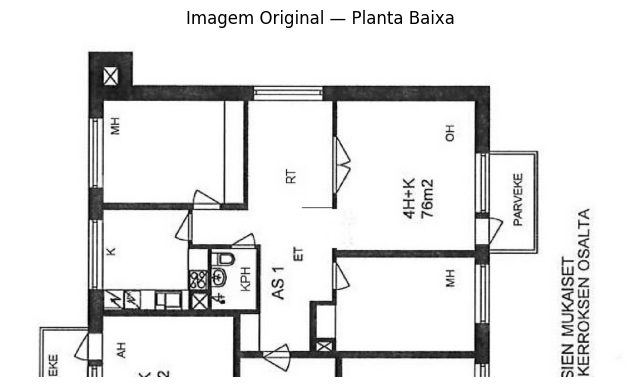

In [17]:
# =============================================================================
# Carregamento da imagem em escala de cinza
# =============================================================================
# imread(..., as_gray=True) retorna valores em [0.0, 1.0] → multiplicamos por 255
imagem_original = (imread('1208.png.jpg', as_gray=True) * 255).astype('uint8')
print(f"Dimensões da imagem: {imagem_original.shape} (altura x largura)")

plt.figure(figsize=(8, 6))
plt.imshow(imagem_original, cmap='gray')
plt.title("Imagem Original — Planta Baixa")
plt.axis('off')
plt.show()

---
## Binarização e Inversão
---
**Binarização:** Cada pixel é classificado como fundo (1 = branco) ou objeto (0 = preto)  
usando um limiar fixo de 200 na escala de cinza.

**Inversão:** Após inverter, os objetos de interesse (paredes, portas, etc.) ficam com  
valor 1 (branco) e o fundo com valor 0 (preto). Isso é necessário porque a morfologia  
matemática opera sobre pixels brancos como "primeiro plano".

In [18]:
# =============================================================================
# Funções de binarização e inversão
# =============================================================================
def binarizar(imagem, limiar=200):
    """
    Converte imagem em escala de cinza para binária (0 e 1).

    Lógica:
    - Pixels com valor <= limiar  →  0 (objeto / preto na original)
    - Pixels com valor >  limiar  →  1 (fundo / branco na original)

    Se a imagem vier colorida (3 canais), converte para cinza antes
    usando a fórmula de luminância: 0.299R + 0.587G + 0.114B
    """
    if len(imagem.shape) == 3:
        imagem = np.dot(imagem[..., :3], [0.299, 0.587, 0.114])

    imagem_binaria = np.where(imagem <= limiar, 0, 1).astype(np.uint8)
    return imagem_binaria


def inverter(imagem_binaria):
    """
    Inverte uma imagem binária: 0 → 1 e 1 → 0.
    Necessário para que os objetos (paredes, portas) sejam o primeiro plano (1).
    """
    return 1 - imagem_binaria

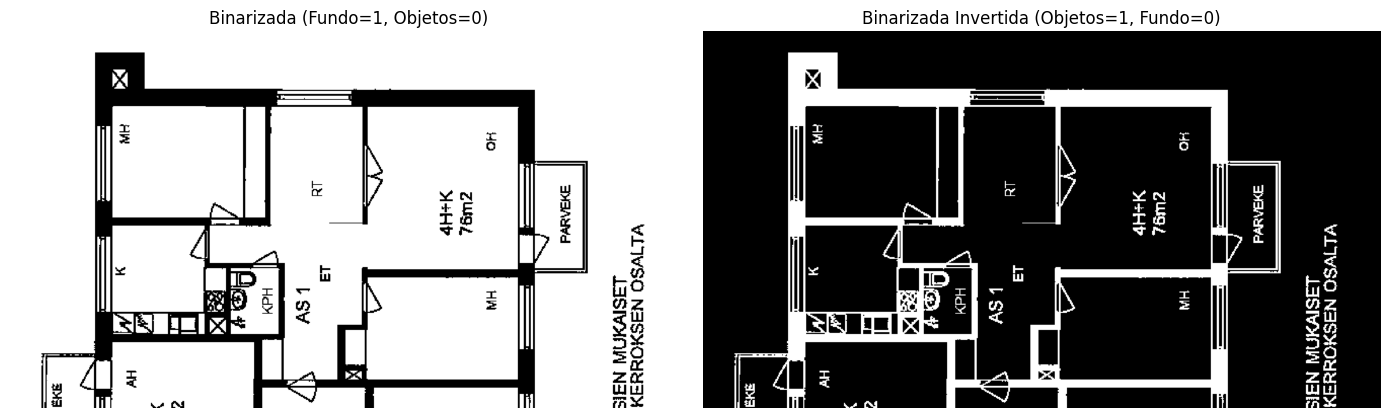

In [19]:
# =============================================================================
# Execução da binarização
# =============================================================================
imagem_binaria = binarizar(imagem_original)
imagem_binaria_invertida = inverter(imagem_binaria)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.imshow(imagem_binaria, cmap='gray')
ax1.set_title("Binarizada (Fundo=1, Objetos=0)")
ax1.axis('off')

ax2.imshow(imagem_binaria_invertida, cmap='gray')
ax2.set_title("Binarizada Invertida (Objetos=1, Fundo=0)")
ax2.axis('off')
plt.tight_layout()
plt.show()

---
## Remoção de Texto por Propriedades dos Componentes Conexos
---
Plantas baixas contêm rótulos de texto (nomes de cômodos, medidas, etc.) que  
atrapalham a detecção de paredes e portas.

**Estratégia:** Rotulamos cada "ilha" de pixels brancos e analisamos suas propriedades  
geométricas. Texto se diferencia de paredes por ser:
- **Compacto** (razão de aspecto entre 0.2 e 3.0, nem muito fino nem muito largo)
- **Com buracos** (letras como A, B, O, 8 têm buracos → Euler number < 1)
- **Pouco sólido** (solidez < 0.95 → área real / área do convex hull)

In [20]:
# =============================================================================
# Remoção de texto por análise de componentes conexos
# =============================================================================
def remover_texto_por_propriedades(img_bin_invertida, area_min, area_max):
  """
  Remove componentes conexos que se comportam como caracteres de texto.

  Critérios combinados:
   1. Área pequena (entre area_min e area_max pixels)
   2. Razão de aspecto de letra (0.2 < largura/altura < 3.0)
   3. Solidez baixa (< 0.95) → objeto tem concavidades
   4. Euler number < 1 → objeto tem buracos internos

  Um componente é removido se for pequeno E (tiver formato de letra OU tiver buracos).
    Parâmetros:
      img_bin_invertida: Imagem binária com objetos=1, fundo=0
      area_min: Área mínima para considerar (ignora ruído)
      area_max: Área máxima para considerar como texto
    Retorna:
      img_sem_texto: Imagem limpa (sem texto)
       mascara_texto: Máscara booleana mostrando o que foi removido
    """

  # label() atribui um número inteiro diferente para cada componente conexo
  # (cada "ilha" isolada de pixels brancos recebe um ID único)
  rotulos = label(img_bin_invertida)
  propriedades = regionprops(rotulos)

  mascara_texto = np.zeros_like(img_bin_invertida, dtype=bool)
  contador_texto = 0

  for prop in propriedades:
    # --- Critério 1: Área ---
    eh_pequeno = area_min < prop.area < area_max

    # --- Critério 2: Razão de aspecto do bounding box ---
    minr, minc, maxr, maxc = prop.bbox # bbox = (linha_min, col_min, linha_max, col_max)
    altura_bbox = maxr - minr
    largura_bbox = maxc - minc
    razao_aspecto = largura_bbox / (altura_bbox + 0.1) # +0.1 evita divisão por zero
    eh_formato_letra = 0.2 < razao_aspecto < 3.0

    # --- Critério 3: Solidez ---
    # solidez = area_objeto / area_convex_hull (1.0 = totalmente sólido)
    eh_pouco_solido = prop.solidity < 0.95

    # --- Critério 4: Número de Euler ---
    # euler_number = componentes - buracos (letras com buracos têm euler < 1)
    tem_buracos = prop.euler_number < 1

    # --- Decisão combinada ---
    if eh_pequeno and (eh_formato_letra or tem_buracos):
      coordenadas = prop.coords # Array Nx2 com (linha, coluna) de cada pixel do objeto
      mascara_texto[coordenadas[:, 0], coordenadas[:, 1]] = True
      contador_texto += 1

  print(f"Componentes analisados: {len(propriedades)} | Texto removido: {contador_texto} caracteres")

  # Remoção: onde tem texto, zera o pixel
  img_sem_texto = img_bin_invertida.copy()
  img_sem_texto[mascara_texto] = 0

  return img_sem_texto, mascara_texto

Tamanho mínimo: 18 pixels
Tamanho máximo: 1833 pixels
18
Componentes analisados: 66 | Texto removido: 56 caracteres


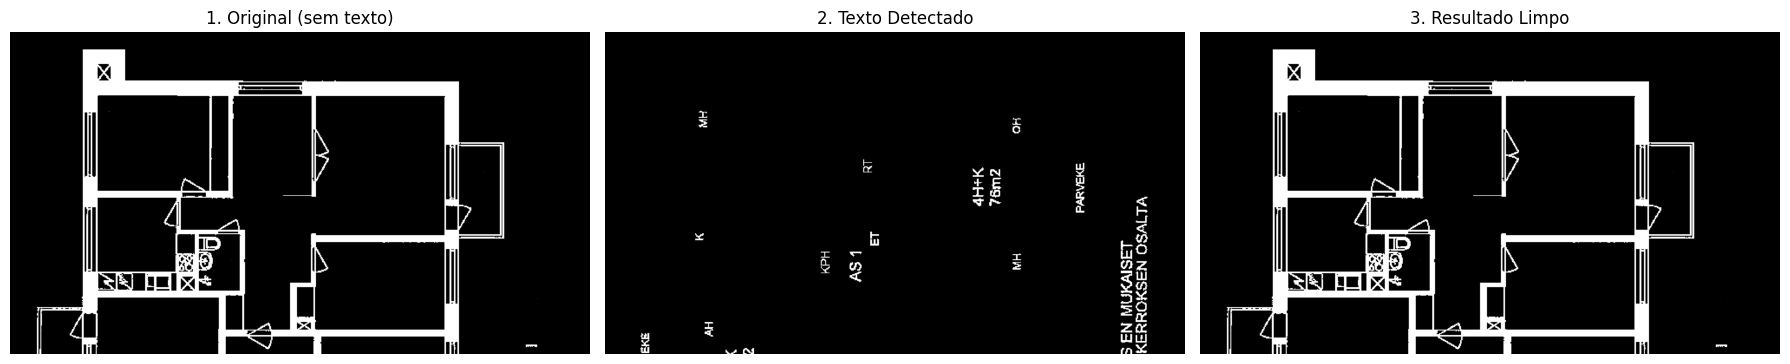

In [21]:
# =============================================================================
# Execução da remoção de texto
# =============================================================================
tamanho_minimo = int(0.01 * max(imagem_binaria.shape))
tamanho_maximo = max(imagem_binaria.shape)
print(f"Tamanho mínimo: {tamanho_minimo} pixels")
print(f"Tamanho máximo: {tamanho_maximo} pixels")

print(comprimento)
imagem_sem_texto, mascara_texto = remover_texto_por_propriedades(imagem_binaria_invertida, tamanho_minimo, tamanho_maximo)
imagem_binaria_invertida = imagem_sem_texto  # Atualiza para uso nas próximas etapas

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(imagem_binaria_invertida, cmap='gray')
ax1.set_title("1. Original (sem texto)")
ax1.axis('off')

ax2.imshow(mascara_texto, cmap='gray')
ax2.set_title("2. Texto Detectado")
ax2.axis('off')

ax3.imshow(imagem_sem_texto, cmap='gray')
ax3.set_title("3. Resultado Limpo")
ax3.axis('off')

plt.tight_layout()
plt.show()

---
## Extração e Filtragem de Paredes
---
**Estratégia em 3 passos:**

1. **Fechamento morfológico** com kernel proporcional a 2% da imagem  
   → conecta pequenas interrupções nas paredes.
2. **Abertura morfológica** com kernel proporcional a 1% da imagem  
   → remove tudo mais fino que a espessura típica de uma parede (portas, texto residual).
3. **Afinamento** do resultado → esqueleto de 1 pixel de largura para  
   localizar com precisão o eixo central de cada parede.

In [22]:
# =============================================================================
# Fechamento e Abertura para isolar paredes
# =============================================================================
# --- Passo 1: Fechamento (dilata → erode) ---
# Conecta pequenas falhas/interrupções nas paredes
tamanho_kernel_fechamento = int(0.005* min(imagem_original.shape))
print(f"Kernel de fechamento: {tamanho_kernel_fechamento}x{tamanho_kernel_fechamento}")
kernel_fechamento = np.ones((tamanho_kernel_fechamento, tamanho_kernel_fechamento), dtype=np.uint8)
imagem_binaria_invertida_fechada = binary_closing(imagem_binaria_invertida, structure=kernel_fechamento)

# --- Passo 2: Abertura (erode → dilata) ---
# Remove objetos mais finos que o kernel (portas, textos, linhas finas)
tamanho_kernel_abertura = int(0.01 * min(imagem_original.shape))
print(f"Kernel de abertura: {tamanho_kernel_abertura}x{tamanho_kernel_abertura}")
kernel_abertura = np.ones((tamanho_kernel_abertura, tamanho_kernel_abertura), dtype=np.uint8)

# Abertura sobre o resultado do fechamento → paredes limpas
imagem_sem_portas = binary_opening(imagem_binaria_invertida_fechada, structure=kernel_abertura)

# Abertura sobre a imagem original invertida (para referência)
imagem_paredes = binary_opening(imagem_binaria_invertida, structure=kernel_abertura)

Kernel de fechamento: 5x5
Kernel de abertura: 10x10


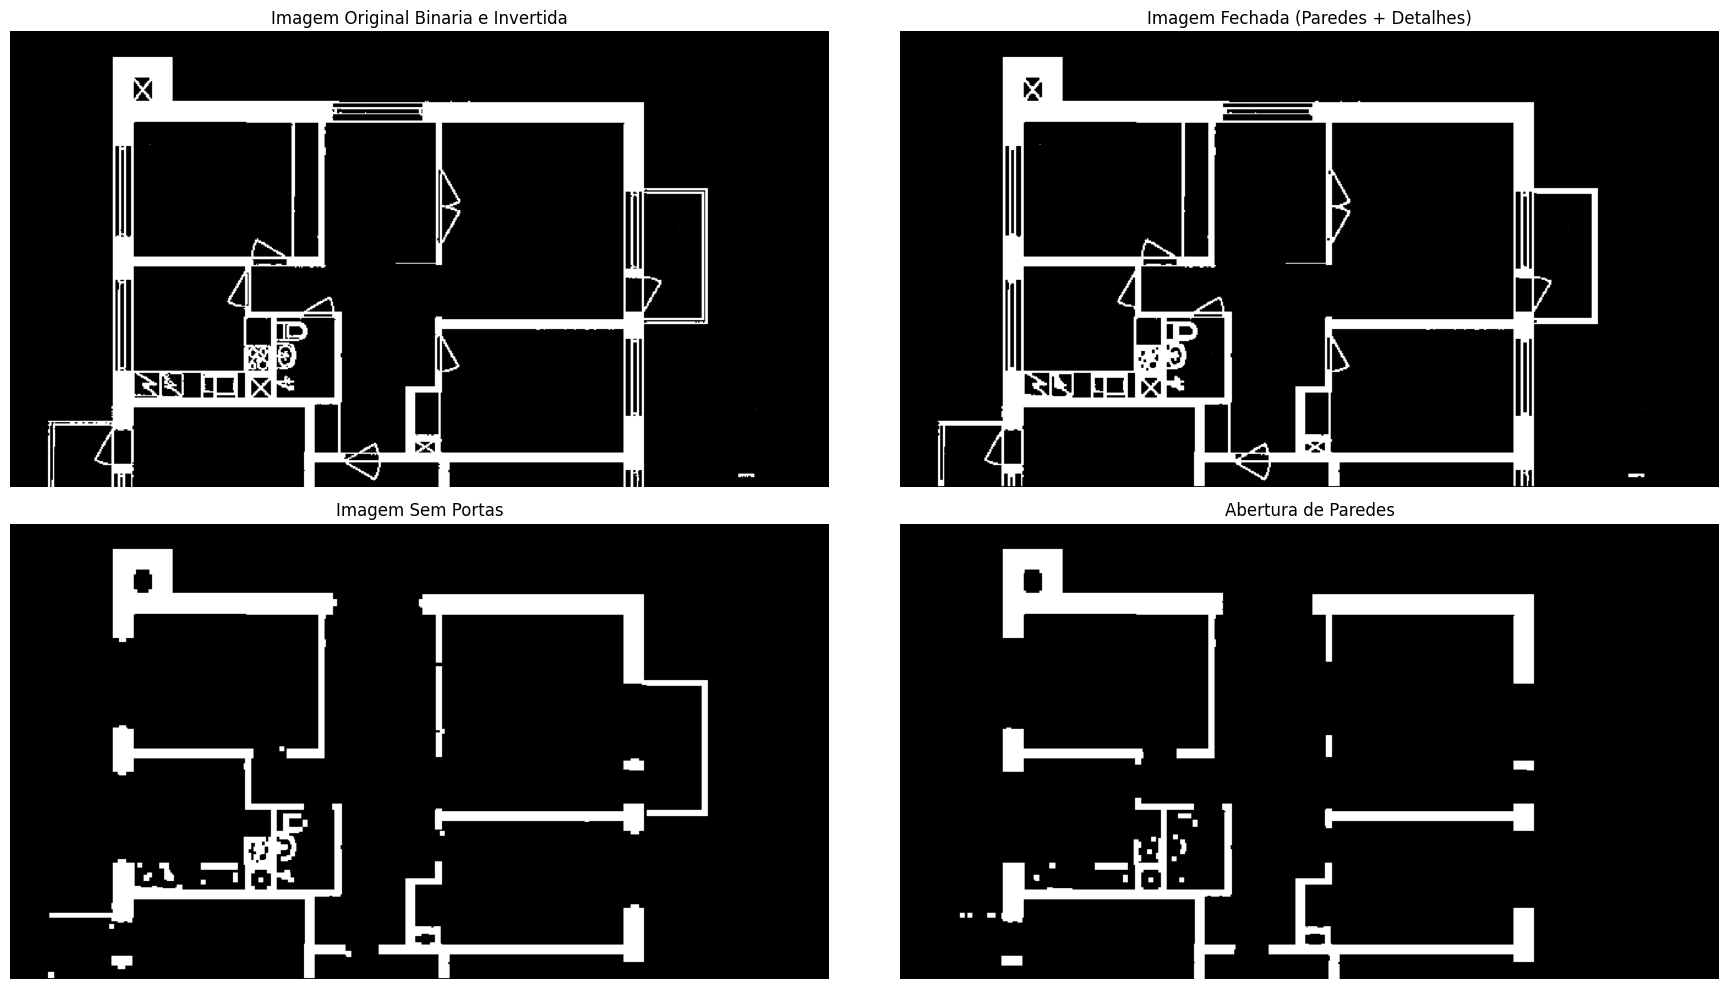

In [23]:
# =============================================================================
# Visualização: Paredes
# =============================================================================
# 1. Ajuste no figsize: (18, 10) dá mais espaço vertical para as 2 linhas não ficarem esmagadas
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# 2. O 'flatten()' transforma a matriz 2x2 [[ax1, ax2], [ax3, ax4]] em uma lista [ax1, ax2, ax3, ax4]
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.imshow(imagem_binaria_invertida, cmap='gray')
ax1.set_title("Imagem Original Binaria e Invertida")
ax1.axis('off')

ax2.imshow(imagem_binaria_invertida_fechada, cmap='gray')
ax2.set_title("Imagem Fechada (Paredes + Detalhes)")
ax2.axis('off')

ax3.imshow(imagem_sem_portas, cmap='gray')
ax3.set_title("Imagem Sem Portas")
ax3.axis('off')

ax4.imshow(imagem_paredes, cmap='gray')
ax4.set_title("Abertura de Paredes")
ax4.axis('off')

plt.tight_layout()
plt.show()

---
## Detecção de Paredes
---

### Filtro de Sobel
A partir da imagem binarizada invertida após o fechamento morfológico,
aplicamos o filtro de Sobel para extrair o contorno das paredes.

O Sobel calcula o gradiente de intensidade da imagem — onde há transição
brusca entre pixels brancos (parede) e pretos (fundo), o gradiente é alto,
revelando as bordas. Como as paredes são os maiores blocos sólidos da
planta, suas bordas formam naturalmente os contornos retangulares que
delimitam cada cômodo.

**Observação:** Dependendo da planta, o resultado pode incluir também
trechos de janelas, uma vez que estas ficam embutidas nas paredes e
compartilham suas bordas. Essa sobreposição é tratada nas etapas
posteriores de detecção de janelas.

In [24]:
def filtro_de_sobel(imagem, kernel1, kernel2):
    """
    Aplica o operador Sobel explorando a separabilidade dos kernels.

    O kernel Sobel 3x3 pode ser decomposto em dois vetores 1D:
    - kernel_suavizacao [1,2,1]: suaviza (média ponderada) em uma direção
    - kernel_derivacao [-1,0,1]: calcula a derivada (diferença) na outra direção

    Isso reduz a complexidade de O(n²) para O(2n) por pixel.

    Parâmetros:
        imagem: array 2D - imagem de entrada
        kernel1: array 1D - primeiro componente (aplicado horizontalmente)
        kernel2: array 1D - segundo componente (aplicado verticalmente)
    Retorna:
        imagem filtrada com o operador Sobel separável
    """
    # Convolução 1D ao longo das linhas (horizontal)
    temp = convolve2d(imagem, kernel1.reshape(1, -1), mode='same')

    # Convolução 1D ao longo das colunas (vertical)
    resultado = convolve2d(temp, kernel2.reshape(-1, 1), mode='same')

    return resultado


In [25]:
# =============================================================================
# Marcação de paredes com retângulos verdes
# =============================================================================

def marcar_paredes_sobel(ax, img_paredes):
    """
    Marca o perímetro das paredes usando o filtro de Sobel.

    O Sobel calcula o gradiente da imagem nas direções X e Y.
    Onde o gradiente é alto = transição de 1→0 ou 0→1 = borda da parede.
    A magnitude do gradiente nos dá o contorno retangular das paredes.

    Parâmetros:
        ax: Eixo do matplotlib para desenho
        img_paredes: Paredes combinadas (H + V), binária
    """
    # Converte para float (sobel precisa de valores contínuos)
    img_float = img_paredes.astype(np.float64)

    # sobel() da scipy.ndimage calcula a magnitude do gradiente:
    # internamente aplica dois kernels 3x3 (horizontal e vertical)
    # Gx = [[-1,0,1],[-2,0,2],[-1,0,1]]  → detecta bordas verticais
    # Gy = [[-1,-2,-1],[0,0,0],[1,2,1]]   → detecta bordas horizontais
    # magnitude = sqrt(Gx² + Gy²)
    # Componentes 1D do operador Sobel
    kernel_suavizacao = np.array([1, 2, 1])   # Suavização gaussiana
    kernel_derivacao = np.array([-1, 0, 1])  # Aproximação da derivada

    # Gx: Detecta bordas verticais (variação horizontal)
    gx = filtro_de_sobel(img_paredes, kernel_suavizacao, kernel_derivacao)

    # Gy: Detecta bordas horizontais (variação vertical)
    gy = filtro_de_sobel(img_paredes, kernel_derivacao, kernel_suavizacao)

    # Magnitude do gradiente (aproximação L1)
    bordas_sobel = np.abs(gx) + np.abs(gy)

    # Binariza o resultado: onde o gradiente é > 0 tem borda
    mascara_borda = bordas_sobel > 0.01  # limiar baixo pois a imagem já é binária
    # Plota os pixels de borda em verde
    bordas_y, bordas_x = np.where(mascara_borda)
    ax.plot(bordas_x, bordas_y, 's', color='green', markersize=2, alpha=0.8)

    print(f"Pixels de borda (Sobel): {len(bordas_y)}")
    return len(bordas_y)

Pixels de borda (Sobel): 30756


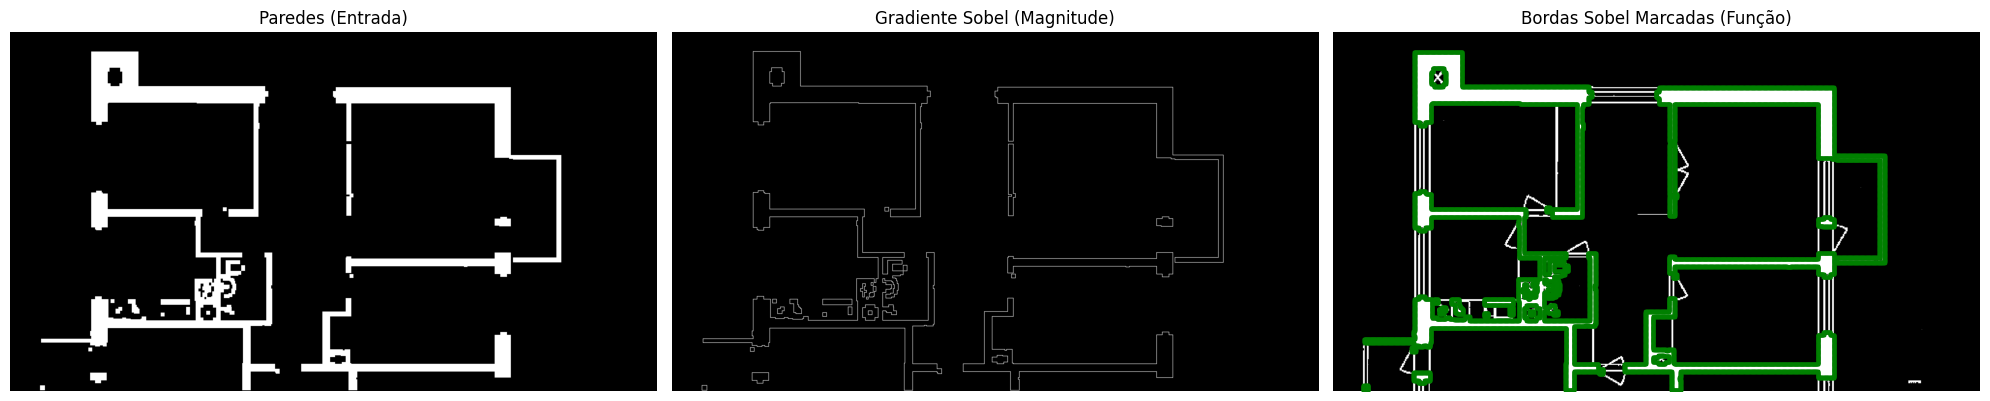

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# --- Imagem Original (Entrada) ---
ax1.imshow(imagem_sem_portas, cmap='gray')
ax1.set_title("Paredes (Entrada)")
ax1.axis('off')

# --- Magnitude do Sobel (Visualização do Gradiente) ---
k_suave = np.array([1, 2, 1])
k_deriv = np.array([-1, 0, 1])
gx_vis = filtro_de_sobel(imagem_sem_portas, k_suave, k_deriv)
gy_vis = filtro_de_sobel(imagem_sem_portas, k_deriv, k_suave)
magnitude_vis = np.abs(gx_vis) + np.abs(gy_vis)

ax2.imshow(magnitude_vis, cmap='gray')
ax2.set_title("Gradiente Sobel (Magnitude)")
ax2.axis('off')

# --- Resultado da Função (Bordas Marcadas) ---
ax3.imshow(imagem_binaria_invertida, cmap='gray')

# Passamos o eixo 'ax3' para ela desenhar em cima dele
marcar_paredes_sobel(ax3, imagem_sem_portas)

ax3.set_title("Bordas Sobel Marcadas (Função)")
ax3.axis('off')

plt.tight_layout()
plt.show()

---
## Detecção de Portas
---

### Extração de Detalhes (portas, janelas, mobília)

A diferença entre a imagem fechada e a imagem só sem  portas nos dá  
todos os "detalhes" da planta que precisamos para identificar as portas.

Aplicamos novamente a remoção de linhas retas para isolar os arcos de porta  
(que são curvos e menores que as linhas de parede).

In [27]:
# =============================================================================
# Extração de detalhes: (fechamento) XOR (sem portas) = portas
# =============================================================================
# XOR binário: pixels que estão no fechamento mas NÃO nas paredes
imagem_portas = imagem_binaria_invertida_fechada ^ imagem_sem_portas
imagem_portas[imagem_portas < 0] = 0  # Garante que não haja valores negativos

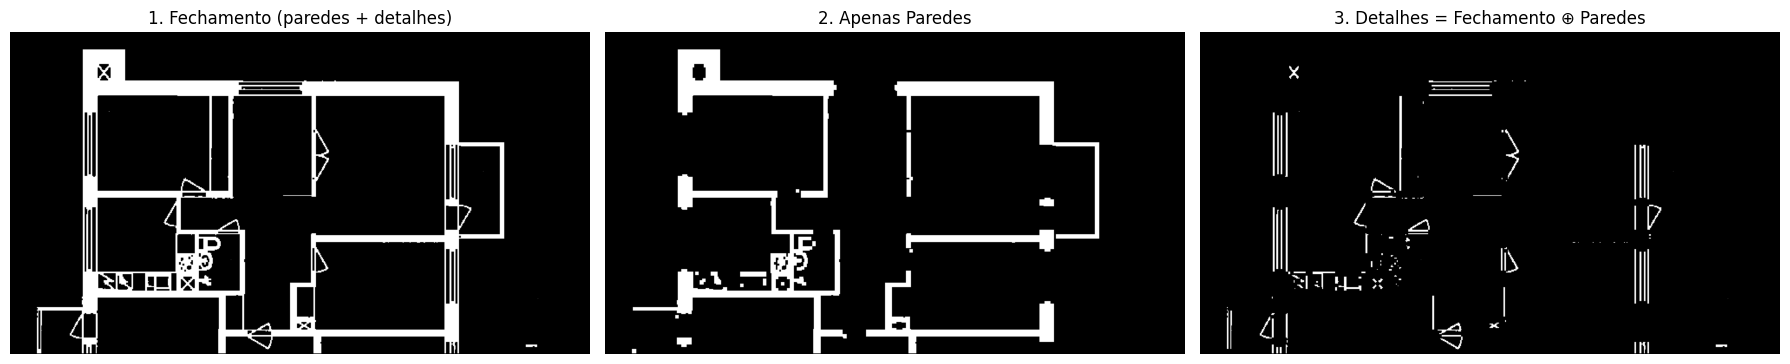

In [28]:
# =============================================================================
# Visualização: fechamento vs sem portas vs detalhes
# =============================================================================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(imagem_binaria_invertida_fechada, cmap='gray')
ax1.set_title("1. Fechamento (paredes + detalhes)")
ax1.axis('off')

ax2.imshow(imagem_sem_portas, cmap='gray')
ax2.set_title("2. Apenas Paredes")
ax2.axis('off')

ax3.imshow(imagem_portas, cmap='gray')
ax3.set_title("3. Detalhes = Fechamento ⊕ Paredes")
ax3.axis('off')

plt.tight_layout()
plt.show()

In [29]:
# =============================================================================
# Função: separar linhas retas de uma imagem
# =============================================================================
def remover_linhas_retas(imagem, tamanho_minimo=10):
    """
    Separa linhas retas (horizontais/verticais) de elementos curvos/pequenos.

    Usa abertura com kernels lineares:
    - Kernel horizontal [1,1,...,1] de tamanho_minimo pixels
    - Kernel vertical   [1;1;...;1] de tamanho_minimo pixels

    A abertura mantém apenas o que "cabe" no kernel, ou seja, linhas
    maiores ou iguais ao tamanho do kernel.

    Retorna:
        img_sem_linhas: Apenas os elementos menores que tamanho_minimo (dobras, curvas)
        linhas_longas: Apenas as linhas retas detectadas
    """
    kernel_horizontal = np.ones((1, tamanho_minimo), dtype=np.uint8)
    kernel_vertical = np.ones((tamanho_minimo, 1), dtype=np.uint8)

    linhas_horizontais = binary_opening(imagem, structure=kernel_horizontal)
    linhas_verticais = binary_opening(imagem, structure=kernel_vertical)

    # União de todas as linhas longas encontradas
    linhas_longas = np.maximum(linhas_horizontais, linhas_verticais)

    # Subtração binária: original AND NOT(linhas) = apenas os detalhes curtos
    img_sem_linhas = np.logical_and(imagem, np.logical_not(linhas_longas))

    return img_sem_linhas.astype(np.uint8), linhas_longas

In [30]:
# =============================================================================
# Separar arcos de linhas retas nos detalhes
# =============================================================================
tamanho_minimo_arco = int(0.05 * min(imagem_original.shape))
print(f"Tamanho mínimo para reta em detalhes: {tamanho_minimo_arco} pixels")

imagem_arcos, imagem_portas_sem_retas = remover_linhas_retas(imagem_portas, tamanho_minimo_arco)

Tamanho mínimo para reta em detalhes: 50 pixels


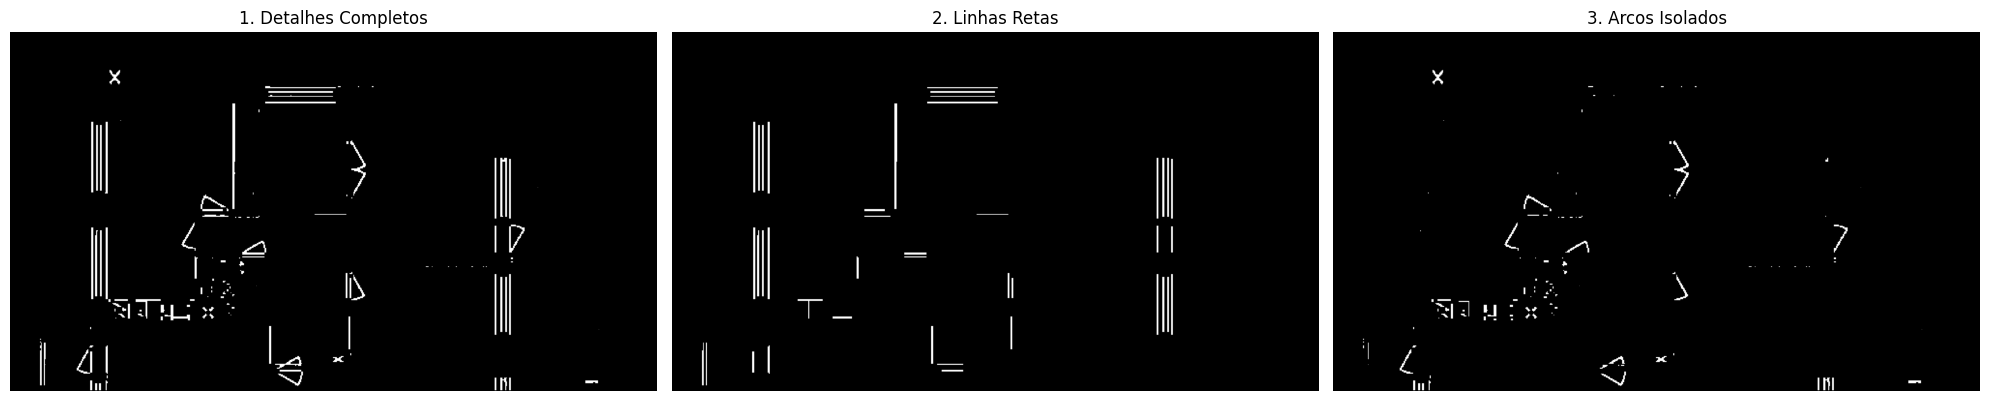

In [31]:
# =============================================================================
# Visualização: detalhes → arcos
# =============================================================================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.imshow(imagem_portas, cmap='gray')
ax1.set_title("1. Detalhes Completos")
ax1.axis('off')

ax2.imshow(imagem_portas_sem_retas, cmap='gray')
ax2.set_title("2. Linhas Retas")
ax2.axis('off')

ax3.imshow(imagem_arcos, cmap='gray')
ax3.set_title("3. Arcos Isolados")
ax3.axis('off')

plt.tight_layout()
plt.show()

---
### Transformada de Hough Circular

A partir da imagem contendo apenas os elementos que não são paredes,
aplicamos a Transformada de Hough Circular para identificar arcos — a
representação clássica de portas em plantas baixas arquitetônicas.

A detecção ocorre em três etapas:

1. **Busca:** A Transformada de Hough Circular varre a imagem procurando
   padrões circulares ou semicirculares, retornando os centros e raios
   mais prováveis para cada arco encontrado.

2. **Filtragem:** Como a busca gera muitos candidatos redundantes
   (vários pontos próximos detectando a mesma porta), aplicamos um filtro
   de proximidade que mantém apenas o melhor resultado em cada região.

3. **Validação:** Cada candidato passa por verificações geométricas —
   continuidade do arco, extensão angular compatível com uma porta e
   conexão com a parede — eliminando falsos positivos como mobília,
   texto residual ou ruído.

In [32]:
def transformada_de_hough_circular(bordas, raios, limiar_votos, num_angulos=360):
    """
    Implementa a Transformada de Hough para Circunferências usando acumulador.

    Diferente da versão adaptada (que testa ponto a ponto no esqueleto),
    esta usa o acumulador clássico: cada pixel de borda vota em todos os
    possíveis centros. Picos no acumulador = centros reais de arcos/círculos.

    Parâmetros:
        bordas: Imagem binária com bordas (onde esperamos arcos de porta)
        raios: Array/range de raios a testar
        num_angulos: Resolução angular (360 = 1° por passo)
        limiar_votos: Mínimo de votos para aceitar um centro.
                      Se None, usa 20% do máximo do acumulador.

    Retorna:
        Lista de tuplas (y_centro, x_centro, raio, score)
        — mesmo formato da transformada_de_hough_circular_adaptada
    """
    altura, largura = bordas.shape

    # Pré-calcula senos e cossenos para todos os ângulos
    angulos = np.linspace(0, 2 * np.pi, num_angulos, endpoint=False)
    cos_theta = np.cos(angulos)
    sin_theta = np.sin(angulos)

    # Coordenadas dos pixels de borda
    y_bordas, x_bordas = np.where(bordas > 0)
    print(f"Pixels de borda: {len(x_bordas)}")

    # --- Acumulador separado por raio ---
    # Um acumulador por raio permite saber QUAL raio recebeu mais votos
    # em cada posição (se usasse um único acumulador, perderíamos o raio)
    portas_encontradas = []

    for raio in raios:
        acumulador = np.zeros((altura, largura), dtype=np.int32)

        # Pré-calcula os offsets de votação para este raio
        # Cada pixel de borda vota em todos os centros possíveis a distância 'raio'
        offsets_cx = (raio * cos_theta).astype(int)
        offsets_cy = (raio * sin_theta).astype(int)

        for x, y in zip(x_bordas, y_bordas):
            # Centros candidatos = pixel de borda - offset
            cx = x - offsets_cx
            cy = y - offsets_cy

            # Filtra coordenadas dentro da imagem
            mascara_valido = (cx >= 0) & (cx < largura) & (cy >= 0) & (cy < altura)

            # Incrementa votos nas posições válidas
            for idx in np.where(mascara_valido)[0]:
                acumulador[cy[idx], cx[idx]] += 1

        # --- Extração de picos para este raio ---
        # Votos teóricos máximos = num_angulos (se o círculo inteiro existir)
        # Uma porta (~90°) teria ~25% dos votos = num_angulos * 0.25
        limiar_atual = max(int(limiar_votos * np.max(acumulador)), 1)

        # Encontra posições com votos acima do limiar
        y_picos, x_picos = np.where(acumulador >= limiar_atual)

        for yp, xp in zip(y_picos, x_picos):
            votos = acumulador[yp, xp]
            # Score = fração do perímetro que votou neste centro
            # Normaliza pelo número de ângulos (votos máximos possíveis)
            score = votos / num_angulos
            portas_encontradas.append((yp, xp, raio, score))

    print(f"Candidatos brutos (acumulador): {len(portas_encontradas)}")
    return portas_encontradas

In [33]:
# =============================================================================
# Filtro de duplicatas por proximidade
# =============================================================================
def filtrar_melhores_candidatos(candidatos, dist_minima=20, qtde_max_portas=15):
    """
    Remove detecções duplicadas/sobrepostas.

    Ordena por score (melhor primeiro) e descarta candidatos que estão
    a menos de 'dist_minima' pixels de um candidato já aceito.

    Parâmetros:
        candidatos: Lista de (y, x, raio, score)
        dist_minima: Distância mínima entre centros aceitos (em pixels)
        qtde_max_portas: Número máximo de portas a retornar

    Retorna:
        Lista filtrada de (y, x, raio, score)
    """
    candidatos_ordenados = sorted(candidatos, key=lambda c: c[3], reverse=True)
    aceitos = []

    print(f"Filtrando {len(candidatos)} candidatos iniciais...")

    for candidato in candidatos_ordenados:
        cy, cx, raio, score = candidato
        eh_novo = True

        for (ay, ax, ar, ascore) in aceitos:
            distancia = np.sqrt((cx - ax)**2 + (cy - ay)**2)
            if distancia < dist_minima:
                eh_novo = False
                break

        if eh_novo:
            aceitos.append(candidato)

        if len(aceitos) == qtde_max_portas:
            return aceitos

    return aceitos

In [34]:
# =============================================================================
# Execução: busca de arcos de porta
# =============================================================================
altura_img, largura_img = imagem_original.shape

# Raios proporcionais ao tamanho da imagem
raio_minimo = int(0.04 * min(altura_img, largura_img))
raio_maximo = int(0.12 * min(altura_img, largura_img))
pulo_raio = int(0.1 * raio_minimo)
print(f"Raios testados: {raio_minimo} a {raio_maximo}, passo {pulo_raio}")

raios = range(raio_minimo, raio_maximo, pulo_raio)

candidatos_brutos = transformada_de_hough_circular(imagem_arcos, raios, 0.4)

Raios testados: 40 a 122, passo 4
Pixels de borda: 12046
Candidatos brutos (acumulador): 148966


In [35]:
# =============================================================================
# Filtragem dos candidatos
# ===================a==========================================================
distancia_minima = (raio_minimo * 2)-1
qtde_max_portas = 50

candidatos_portas = filtrar_melhores_candidatos(
    candidatos_brutos, distancia_minima, qtde_max_portas
)

Filtrando 148966 candidatos iniciais...


Portas detectadas: 50


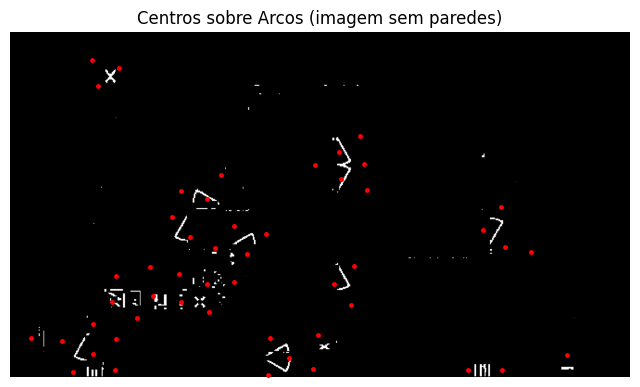

In [36]:
# =============================================================================
# Visualização: centros detectados sobre arcos e esqueleto
# =============================================================================
print(f"Portas detectadas: {len(candidatos_portas)}")

plt.figure(figsize=(8, 6))
plt.imshow(imagem_arcos, cmap='gray')
plt.title("Centros sobre Arcos (imagem sem paredes)")
plt.axis('off')

for y, x, r, score in candidatos_portas:
    plt.plot(x, y, 'r.', markersize=5)

plt.show()

Candidatos encontrados: 50


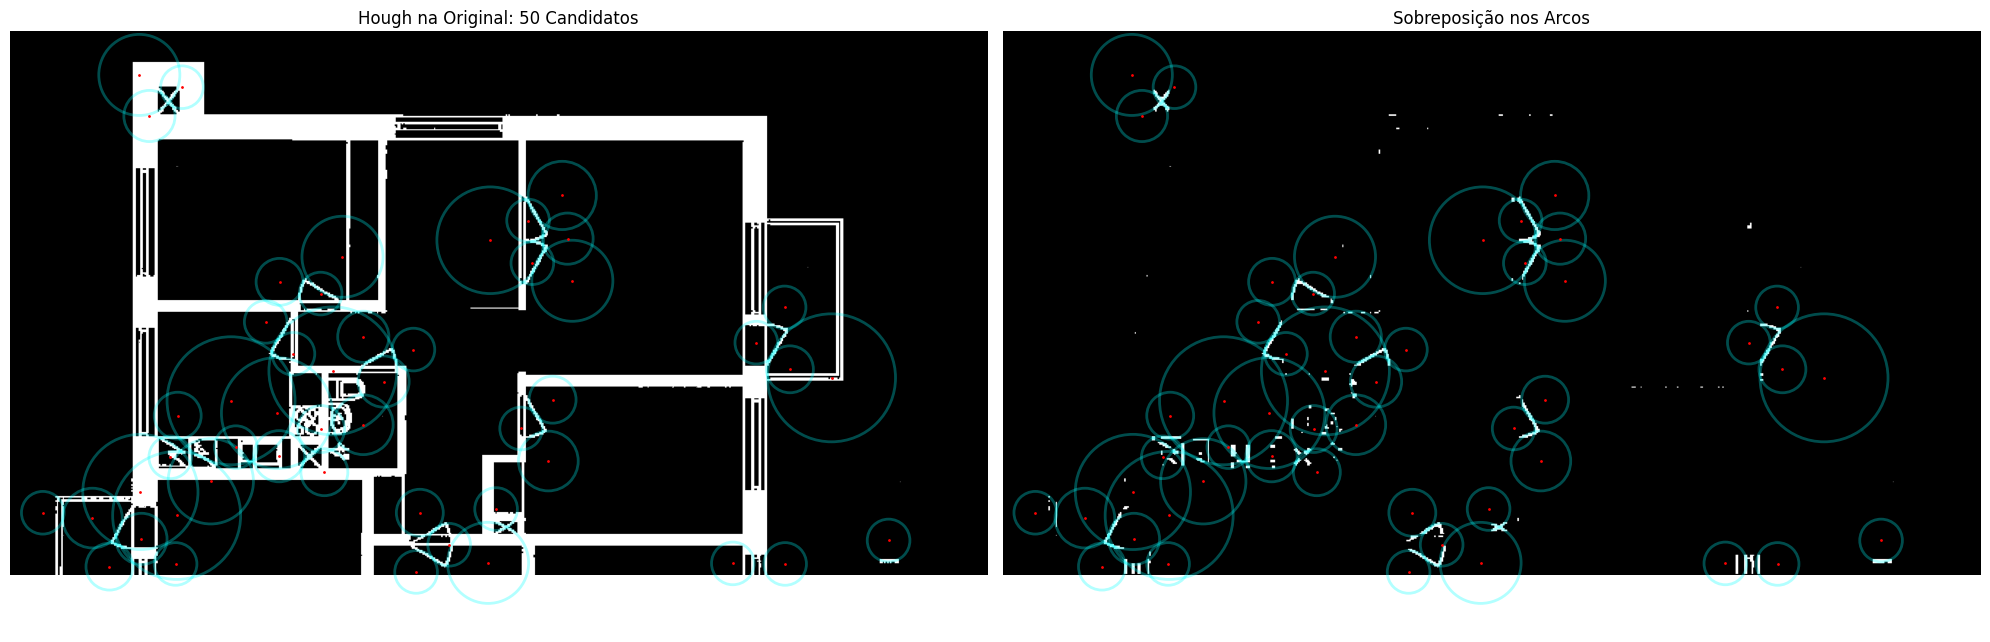

In [37]:
# =============================================================================
# Visualização: círculos completos dos candidatos
# =============================================================================
print(f"Candidatos encontrados: {len(candidatos_portas)}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(imagem_binaria_invertida, cmap='gray')
ax1.set_title(f"Hough na Original: {len(candidatos_portas)} Candidatos")
ax1.axis('off')

ax2.imshow(imagem_arcos, cmap='gray')
ax2.set_title("Sobreposição nos Arcos")
ax2.axis('off')

for y, x, r, score in candidatos_portas:
    circ1 = plt.Circle((x, y), r, color='cyan', fill=False, linewidth=2, alpha=0.3)
    ax1.add_patch(circ1)
    ax1.plot(x, y, 'r.', markersize=2)
    circ2 = plt.Circle((x, y), r, color='cyan', fill=False, linewidth=2, alpha=0.3)
    ax2.add_patch(circ2)
    ax2.plot(x, y, 'r.', markersize=2)

plt.tight_layout()
plt.show()

---
### Validação Final: Desenho dos Arcos Reais

Nem todo candidato detectado é uma porta real. Esta etapa faz uma  
validação rigorosa verificando:

1. **Colisão com parede:** Se mais de **X**% do arco atravessa parede grossa → rejeita
2. **Existência real:** Se menos de **X**% dos pixels existem na imagem → rejeita (fundo vazio)
3. **Continuidade angular:** Calcula os ângulos dos pixels reais e encontra o maior segmento contínuo
4. **Extensão do arco:** Deve ter entre `min_cobertura_graus` e 270° (evita círculos completos)

In [38]:
# =============================================================================
# Validação de arcos de porta
# =============================================================================
def validar_arcos_porta(img_arcos, img_paredes, candidatos, min_cobertura_graus=30):
    """
    Valida cada candidato a porta verificando se o arco realmente existe.

    Validações:
    1. Rejeita se > 20% do arco atravessa parede grossa
    2. Rejeita se < 2% dos pixels do arco existem (fundo vazio)
    3. Encontra o maior segmento angular contínuo
    4. Rejeita se o arco é menor que min_cobertura_graus ou > 270°

    Parâmetros:
        img_arcos: Imagem sem paredes (onde esperamos encontrar arcos)
        img_paredes: Imagem de paredes grossas (para rejeitar colisões)
        candidatos: Lista de (y, x, raio, score)
        min_cobertura_graus: Extensão angular mínima para aceitar

    Retorna:
        portas_validadas: Lista de (cy, cx, r, theta1, theta2)
    """
    altura, largura = img_arcos.shape
    portas_validadas = []

    candidatos = sorted(candidatos, key=lambda x: x[3], reverse=True)

    for (cy, cx, r, score_original) in candidatos:
        rr, cc = circle_perimeter(cy, cx, r, shape=(altura, largura))
        if len(rr) == 0:
            continue

        # --- Validação 1: Colisão com parede ---
        pixels_na_parede = np.sum(img_paredes[rr, cc] > 0)
        fracao_na_parede = pixels_na_parede / len(rr)
        if fracao_na_parede > 0.2:
            continue

        # --- Validação 2: Existência real de pixels ---
        mascara_existencia = img_arcos[rr, cc] > 0
        pixels_reais = np.sum(mascara_existencia)
        if pixels_reais < (len(rr) * 0.02):
            continue

        y_reais = rr[mascara_existencia]
        x_reais = cc[mascara_existencia]

        # --- Validação 3: Continuidade angular ---
        angulos_rad = np.arctan2(y_reais - cy, x_reais - cx)
        angulos_graus = np.degrees(angulos_rad)
        angulos_graus = (angulos_graus + 360) % 360
        angulos_graus.sort()

        if len(angulos_graus) < 2:
            continue

        diferencas = np.diff(angulos_graus)
        gap_circular = (angulos_graus[0] + 360) - angulos_graus[-1]
        diferencas = np.append(diferencas, gap_circular)

        limiar_quebra = 10
        indices_quebra = np.where(diferencas > limiar_quebra)[0]

        if len(indices_quebra) == 0:
            continue

        fronteiras = np.concatenate(([-1], indices_quebra))
        melhor_segmento = None
        maior_extensao = 0

        for j in range(len(fronteiras) - 1):
            idx_inicio = fronteiras[j] + 1
            idx_fim = fronteiras[j + 1]
            segmento = angulos_graus[idx_inicio:idx_fim + 1]

            if len(segmento) < 2:
                continue

            extensao = segmento[-1] - segmento[0]
            if extensao > maior_extensao:
                maior_extensao = extensao
                melhor_segmento = (segmento[0], segmento[-1])

        if gap_circular <= limiar_quebra and len(indices_quebra) >= 1:
            extensao_wrap = (angulos_graus[indices_quebra[0]] + 360) - angulos_graus[indices_quebra[-1] + 1]
            if extensao_wrap > maior_extensao:
                maior_extensao = extensao_wrap
                melhor_segmento = (angulos_graus[indices_quebra[-1] + 1],
                                   angulos_graus[indices_quebra[0]] + 360)

        # --- Validação 4: Extensão angular ---
        if melhor_segmento and (min_cobertura_graus < maior_extensao < 270):
            theta1, theta2 = melhor_segmento
            portas_validadas.append((cy, cx, r, theta1, theta2))

    print(f"Portas validadas: {len(portas_validadas)}")
    return portas_validadas

In [39]:
# =============================================================================
# Validação e desenho de arcos reais de porta
# =============================================================================
def desenhar_arcos_reais(img_fundo, img_arcos, img_paredes, candidatos, min_cobertura_graus=30):
    """
    Valida cada candidato a porta e desenha apenas o segmento de arco que realmente existe.

    Validações:
    1. Rejeita se > 10% do arco está dentro de uma parede grossa
    2. Rejeita se < 5% dos pixels do arco existem (fundo vazio)
    3. Encontra o maior segmento angular contínuo
    4. Rejeita se o arco é menor que min_cobertura_graus ou > 270°

    Parâmetros:
        img_fundo: Imagem para exibição (geralmente imagem_binaria_invertida)
        img_arcos: Imagem com detalhes/arcos (onde buscamos a porta)
        img_paredes: Imagem com paredes grossas (para rejeitar colisões)
        candidatos: Lista de (y, x, raio, score)
        min_cobertura_graus: Extensão angular mínima para aceitar o arco

    Retorna:
        portas_validadas_lista: Lista de tuplas (cy, cx, r, theta1, theta2) das portas validadas
    """
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img_fundo, cmap='gray')
    ax.set_title("Validação Final: Arcos Reais Detectados")

    altura, largura = img_fundo.shape
    portas_validadas = 0
    portas_validadas_lista = []

    candidatos = sorted(candidatos, key=lambda x: x[3], reverse=True)

    for (cy, cx, r, score_original) in candidatos:
        rr, cc = circle_perimeter(cy, cx, r, shape=(altura, largura))
        if len(rr) == 0:
            continue

        # --- Validação 1: Colisão com parede ---
        pixels_na_parede = np.sum(img_paredes[rr, cc] > 0)
        fracao_na_parede = pixels_na_parede / len(rr)
        if fracao_na_parede > 0.2:
            continue

        # --- Validação 2: Existência real de pixels ---
        mascara_existencia = img_arcos[rr, cc] > 0
        pixels_reais = np.sum(mascara_existencia)
        if pixels_reais < (len(rr) * 0.02):
            continue

        # Coordenadas dos pixels que realmente existem
        y_reais = rr[mascara_existencia]
        x_reais = cc[mascara_existencia]

        # --- Validação 3: Continuidade angular ---
        # arctan2 calcula o ângulo de cada pixel em relação ao centro
        angulos_rad = np.arctan2(y_reais - cy, x_reais - cx)
        angulos_graus = np.degrees(angulos_rad)
        angulos_graus = (angulos_graus + 360) % 360  # Normaliza para [0, 360)
        angulos_graus.sort()

        # Encontra quebras (gaps maiores que 10° entre pixels consecutivos)
        diferencas = np.diff(angulos_graus)
        gap_circular = (angulos_graus[0] + 360) - angulos_graus[-1]
        diferencas = np.append(diferencas, gap_circular)

        limiar_quebra = 10  # graus
        indices_quebra = np.where(diferencas > limiar_quebra)[0]

        if len(indices_quebra) == 0:
            continue  # Círculo completo → provavelmente não é porta

        # Busca o maior segmento contínuo de arco
        fronteiras = np.concatenate(([-1], indices_quebra))
        melhor_segmento = None
        maior_extensao = 0

        for j in range(len(fronteiras) - 1):
            idx_inicio = fronteiras[j] + 1
            idx_fim = fronteiras[j + 1]
            segmento = angulos_graus[idx_inicio:idx_fim + 1]

            if len(segmento) < 2:
                continue

            extensao = segmento[-1] - segmento[0]
            if extensao > maior_extensao:
                maior_extensao = extensao
                melhor_segmento = (segmento[0], segmento[-1])

        # Verifica segmento que cruza 0°/360° (wrap-around)
        if gap_circular <= limiar_quebra:
            extensao_wrap = (angulos_graus[indices_quebra[0]] + 360) - angulos_graus[indices_quebra[-1] + 1]
            if extensao_wrap > maior_extensao:
                maior_extensao = extensao_wrap
                melhor_segmento = (angulos_graus[indices_quebra[-1] + 1], angulos_graus[indices_quebra[0]] + 360)

        # --- Validação 4: Extensão angular ---
        if melhor_segmento and (min_cobertura_graus < maior_extensao < 270):
            theta1, theta2 = melhor_segmento

            arco_patch = Arc((cx, cy), width=2*r, height=2*r,
                             theta1=theta1, theta2=theta2,
                             color='cyan', linewidth=3)
            ax.add_patch(arco_patch)
            ax.plot(cx, cy, 'r.', markersize=5)
            portas_validadas += 1
            portas_validadas_lista.append((cy, cx, r, theta1, theta2))

    print(f"Portas validadas e desenhadas: {portas_validadas}")
    plt.axis('off')
    plt.show()

    return portas_validadas_lista

Portas validadas e desenhadas: 35


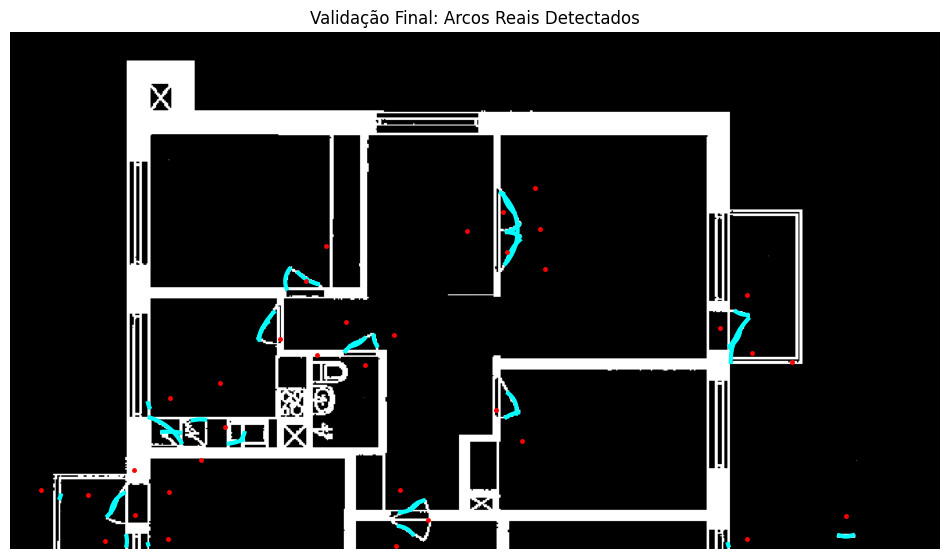

In [40]:
# =============================================================================
# Execução: validação final dos arcos de porta
# =============================================================================
lista_portas_validadas = desenhar_arcos_reais(
    imagem_binaria_invertida, imagem_portas, imagem_paredes, candidatos_portas, 10
)

### Transformada de Hough Linear: Detecção de Segmentos de Reta
A função `transformada_de_hough_linear` implementa uma versão manual e adaptada do algoritmo clássico. Enquanto a Hough padrão retorna parâmetros de retas infinitas ($\rho, \theta$), esta implementação realiza um pós-processamento crucial para identificar **segmentos de reta finitos** (a folha da porta).

**O Processo em 3 Etapas:**

1.  **Votação no Espaço de Parâmetros:**
    * Mapeia cada pixel de borda $(x,y)$ para curvas senoidais no espaço $(\rho, \theta)$.
    * Onde muitas curvas se interceptam (picos no acumulador), existe uma reta colinear na imagem.

2.  **Supressão de Não-Máximos (NMS):**
    * Filtra o acumulador para encontrar apenas os picos mais fortes, evitando que uma única reta grossa gere múltiplas linhas duplicadas.

3.  **Extração de Segmentos (O Diferencial):**
    * Para cada reta infinita detectada, o algoritmo "caminha" pixel a pixel ao longo de sua trajetória na imagem original.
    * Ele verifica a continuidade dos pixels de borda. Se encontrar um "buraco" (sequência de pixels pretos) maior que o `gap_maximo`, ele quebra a linha.
    * **Resultado:** Em vez de dizer "existe uma reta aqui", o algoritmo diz "existe um segmento do pixel A ao pixel B". Isso é essencial para desenhar a porta exatamente onde ela está, e não uma linha atravessando a sala toda.

In [41]:
# =============================================================================
# Transformada de Hough Linear
# =============================================================================
def transformada_de_hough_linear(imagem_bordas, resolucao_theta=1, limiar_votos=None,
                                  tamanho_vizinhanca=15, gap_maximo=5, comprimento_minimo=10):
    """
    Implementação manual da Transformada de Hough para detecção de linhas retas.

    Retorna segmentos reais (com ponto inicial e final) em vez de retas infinitas.
    Percorre cada reta detectada na imagem e quebra em segmentos contíguos
    onde existem pixels de borda, respeitando um gap máximo entre pixels.

    Parâmetros:
        imagem_bordas: Imagem binária (1 = borda, 0 = fundo)
        resolucao_theta: Resolução angular em graus (default: 1°)
        limiar_votos: Mínimo de votos para aceitar uma reta.
                      Se None, usa 50% do máximo do acumulador.
        tamanho_vizinhanca: Janela para NMS no acumulador
        gap_maximo: Máximo de pixels pretos consecutivos tolerados dentro de
                    um segmento. Se o buraco for maior que isso, quebra em dois
                    segmentos separados. (default: 5 pixels)
        comprimento_minimo: Comprimento mínimo em pixels para aceitar um segmento.
                            Segmentos menores que isso são descartados como ruído.
                            (default: 10 pixels)

    Retorna:
        acumulador: Matriz de votos (rho x theta)
        rhos: Array com os valores de rho
        thetas: Array com os valores de theta (radianos)
        segmentos_detectados: Lista de ((x1,y1), (x2,y2), rho, theta)
                              Cada entrada é um segmento real com início, fim
                              e os parâmetros da reta original.
    """
    altura, largura = imagem_bordas.shape

    # --- Passo 1: Espaço de parâmetros ---
    diagonal = int(np.ceil(np.sqrt(altura**2 + largura**2)))
    rhos = np.arange(-diagonal, diagonal + 1, 1)
    thetas = np.deg2rad(np.arange(0, 180, resolucao_theta))

    num_rhos = len(rhos)
    num_thetas = len(thetas)
    acumulador = np.zeros((num_rhos, num_thetas), dtype=np.int32)

    cos_thetas = np.cos(thetas)
    sin_thetas = np.sin(thetas)

    # --- Passo 2: Votação ---
    y_bordas, x_bordas = np.where(imagem_bordas > 0)

    for i in range(len(x_bordas)):
        x = x_bordas[i]
        y = y_bordas[i]

        for j in range(num_thetas):
            rho_calculado = int(round(x * cos_thetas[j] + y * sin_thetas[j]))
            indice_rho = rho_calculado + diagonal

            if 0 <= indice_rho < num_rhos:
                acumulador[indice_rho, j] += 1

    # --- Passo 3: Limiar ---
    if limiar_votos is None:
        limiar_votos = int(0.5 * np.max(acumulador))

    print(f"Máximo no acumulador: {np.max(acumulador)} | Limiar: {limiar_votos}")

    # --- Passo 4: NMS ---
    meia_janela = tamanho_vizinhanca // 2
    linhas_hough = []

    candidatos = np.argwhere(acumulador >= limiar_votos)
    candidatos_ordenados = sorted(candidatos, key=lambda c: acumulador[c[0], c[1]], reverse=True)

    suprimido = np.zeros((num_rhos, num_thetas), dtype=bool)

    for (idx_rho, idx_theta) in candidatos_ordenados:
        if suprimido[idx_rho, idx_theta]:
            continue

        linhas_hough.append((rhos[idx_rho], thetas[idx_theta]))

        r_ini = max(0, idx_rho - meia_janela)
        r_fim = min(num_rhos, idx_rho + meia_janela + 1)
        t_ini = max(0, idx_theta - meia_janela)
        t_fim = min(num_thetas, idx_theta + meia_janela + 1)
        suprimido[r_ini:r_fim, t_ini:t_fim] = True

    print(f"Retas após NMS: {len(linhas_hough)}")

    # --- Passo 5: Extrair segmentos reais de cada reta ---
    # Para cada reta (rho, theta), caminha pixel a pixel ao longo dela.
    # Onde encontra pixels brancos contíguos, forma um segmento.
    # Se o gap (distância sem pixels) excede gap_maximo, corta o segmento.
    segmentos_detectados = []

    for rho, theta in linhas_hough:
        cos_t = np.cos(theta)
        sin_t = np.sin(theta)

        # Ponto base (projeção perpendicular)
        x0 = cos_t * rho
        y0 = sin_t * rho

        # Direção ao longo da reta
        dir_x = -sin_t
        dir_y = cos_t

        # Caminha ao longo da reta coletando pixels existentes
        comprimento = max(altura, largura)
        segmento_atual = []   # Pixels do segmento sendo construído
        pixels_sem_hit = 0    # Contador de pixels pretos consecutivos

        for t in range(-comprimento, comprimento):
            px = int(round(x0 + t * dir_x))
            py = int(round(y0 + t * dir_y))

            # Fora da imagem
            if px < 0 or px >= largura or py < 0 or py >= altura:
                # Se estava construindo um segmento, fecha ele
                if len(segmento_atual) >= comprimento_minimo:
                    p_inicio = segmento_atual[0]
                    p_fim = segmento_atual[-1]
                    segmentos_detectados.append((p_inicio, p_fim, rho, theta))
                segmento_atual = []
                pixels_sem_hit = 0
                continue

            if imagem_bordas[py, px] > 0:
                # Pixel branco encontrado
                segmento_atual.append((px, py))
                pixels_sem_hit = 0
            else:
                # Pixel preto
                pixels_sem_hit += 1

                # Gap excedeu o máximo → fecha o segmento atual
                if pixels_sem_hit > gap_maximo and len(segmento_atual) > 0:
                    if len(segmento_atual) >= comprimento_minimo:
                        p_inicio = segmento_atual[0]
                        p_fim = segmento_atual[-1]
                        segmentos_detectados.append((p_inicio, p_fim, rho, theta))
                    segmento_atual = []
                    pixels_sem_hit = 0

        # Fecha último segmento se existir
        if len(segmento_atual) >= comprimento_minimo:
            p_inicio = segmento_atual[0]
            p_fim = segmento_atual[-1]
            segmentos_detectados.append((p_inicio, p_fim, rho, theta))

    print(f"Segmentos reais: {len(segmentos_detectados)}")

    return acumulador, rhos, thetas, segmentos_detectados

In [42]:
acumulador, rhos, thetas, segmentos_detectados = transformada_de_hough_linear(
    imagem_arcos.astype(np.uint8),
    resolucao_theta=1,
    limiar_votos=raio_minimo,
    tamanho_vizinhanca=raio_minimo
)

Máximo no acumulador: 109 | Limiar: 40
Retas após NMS: 176
Segmentos reais: 297


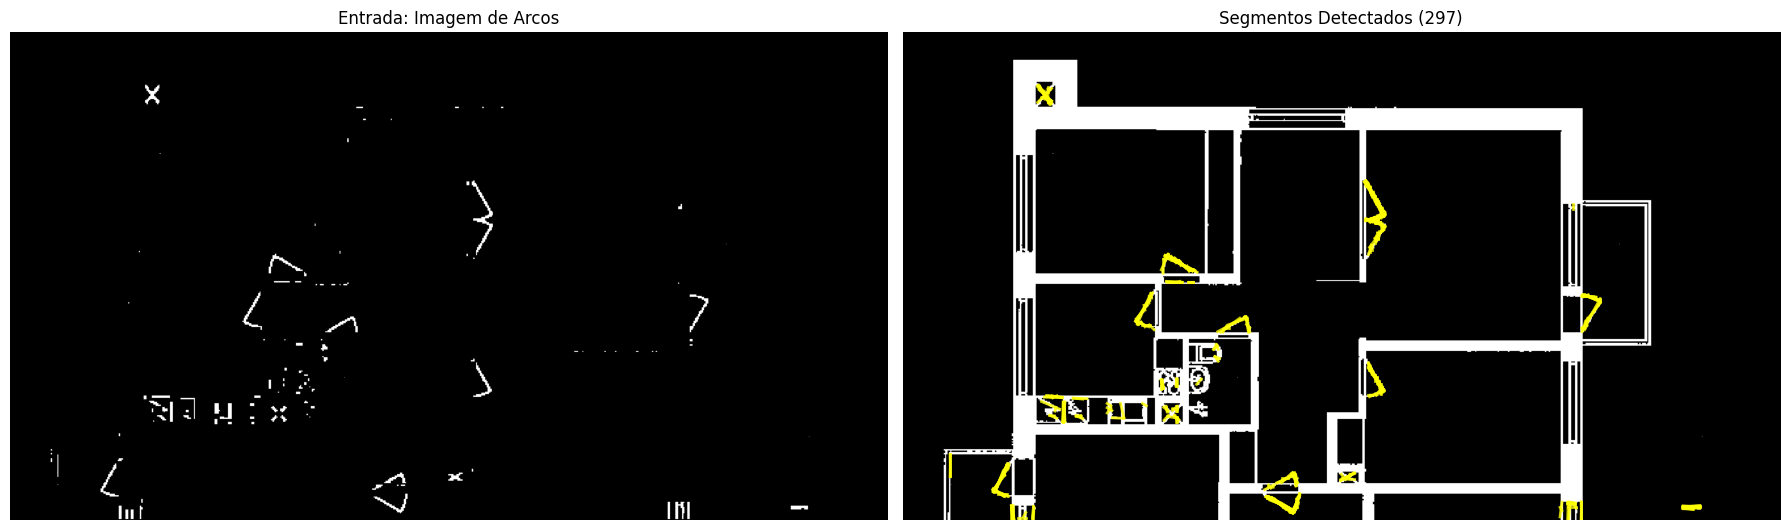

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

ax1.imshow(imagem_arcos, cmap='gray')
ax1.set_title("Entrada: Imagem de Arcos")
ax1.axis('off')

ax2.imshow(imagem_binaria_invertida, cmap='gray')
ax2.set_title(f"Segmentos Detectados ({len(segmentos_detectados)})")

for seg in segmentos_detectados:
    (x1, y1), (x2, y2) = seg[0], seg[1]
    ax2.plot([x1, x2], [y1, y2], color='yellow', linewidth=2, alpha=0.8)

ax2.axis('off')
plt.tight_layout()
plt.show()

### Validação Cruzada: Fusão de Evidências (Arco + Reta)
A função `validar_portas_arco_e_reta` atua como um filtro lógico para confirmar a existência de uma porta. Baseia-se na premissa arquitetônica de que uma porta em planta baixa é um objeto composto por duas partes indissociáveis: a **abertura** (arco) e a **folha** (reta).

**Lógica de Confirmação:**
Uma porta só é validada se houver intersecção espacial entre os resultados da Hough Circular e da Hough Linear.

1.  **Associação Espacial:**
    * Para cada arco detectado (candidato a movimento da porta), o algoritmo define uma região de interesse (ROI) baseada no seu raio e centro.
    * Busca-se, na lista de segmentos lineares, alguma reta que possua pelo menos um de seus extremos dentro dessa região.

2.  **Critério de Eliminação (Falsos Positivos):**
    * **Arco sem Reta:** É descartado como mobília curva, tapete ou ruído de digitalização.
    * **Reta sem Arco:** É descartada como parede, janela, bancada ou degrau.
    * **Arco + Reta:** É classificado como **Porta Confirmada**.

Este método aumenta drasticamente a precisão, pois é estatisticamente improvável que ruídos aleatórios formem um arco perfeito e uma reta perfeita alinhados geometricamente no mesmo local.

In [44]:
def validar_portas_arco_e_reta(candidatos_arcos, segmentos_retas, img_fundo, raio_erro):
    """
    Confirma portas cruzando detecções de arcos (Hough Circular) com
    segmentos de reta (Hough Linear).

    Lógica:
    - Uma porta só é válida se AMBAS as evidências existirem na mesma região:
      1. Um arco (semicírculo da abertura)
      2. Um segmento de reta (a folha da porta)
    - Arco sem reta → falso positivo (mobília, escada, ruído)
    - Reta sem arco → falso positivo (janela, parede, detalhe)
    - Arco + reta na mesma região → porta confirmada

    Verificação:
    Para cada arco candidato (cy, cx, raio), verifica se pelo menos um
    segmento de reta tem ao menos um extremo dentro do círculo definido
    pelo centro e raio do arco, expandido por uma margem fixa baseada
    em 10% do menor raio possível da imagem.

    Parâmetros:
        candidatos_arcos: Lista de (cy, cx, raio, score) da Hough Circular
        segmentos_retas: Lista de ((x1,y1), (x2,y2), rho, theta) da Hough Linear
        img_fundo: Imagem para exibição (usada para calcular a margem)

    Retorna:
        portas_confirmadas: Lista de (cy, cx, raio, score, x1, y1, x2, y2)
    """
    portas_confirmadas = []
    arcos_usados = set()
    retas_usadas = set()

    # Margem fixa: 10% do menor raio possível na imagem
    # O menor raio é 3% da menor dimensão (mesmo cálculo usado na busca)
    altura, largura = img_fundo.shape
    margem_fixa = int(0.5 * raio_erro)
    print(f"Margem de busca: {margem_fixa} pixels (10% de raio mínimo {raio_erro})")

    for idx_arco, candidato in enumerate(candidatos_arcos):
        cy, cx, raio = candidato[0], candidato[1], candidato[2]

        # Raio expandido pela margem fixa
        raio_expandido = raio + margem_fixa
        melhor_reta = None
        melhor_dist = float('inf')

        for idx_reta, seg in enumerate(segmentos_retas):
            (x1, y1), (x2, y2) = seg[0], seg[1]

            dist_p1 = np.sqrt((x1 - cx)**2 + (y1 - cy)**2)
            dist_p2 = np.sqrt((x2 - cx)**2 + (y2 - cy)**2)

            p1_dentro = dist_p1 <= raio_expandido
            p2_dentro = dist_p2 <= raio_expandido

            if p1_dentro or p2_dentro:
                mx = (x1 + x2) / 2
                my = (y1 + y2) / 2
                dist_media = np.sqrt((mx - cx)**2 + (my - cy)**2)

                if dist_media < melhor_dist:
                    melhor_dist = dist_media
                    melhor_reta = (idx_reta, x1, y1, x2, y2)

        if melhor_reta is not None:
            idx_reta, x1, y1, x2, y2 = melhor_reta
            score = candidato[3] if len(candidato) > 3 else 1.0
            portas_confirmadas.append((cy, cx, raio, score, x1, y1, x2, y2))
            arcos_usados.add(idx_arco)
            retas_usadas.add(idx_reta)

    arcos_sem_reta = len(candidatos_arcos) - len(arcos_usados)
    retas_sem_arco = len(segmentos_retas) - len(retas_usadas)

    print(f"Portas confirmadas (arco + reta): {len(portas_confirmadas)}")
    print(f"Arcos descartados (sem reta):     {arcos_sem_reta}")
    print(f"Retas descartadas (sem arco):     {retas_sem_arco}")

    return portas_confirmadas

In [45]:
def marcar_portas(ax, portas_confirmadas):
    """
    Desenha as portas confirmadas (arco + reta) em vermelho.

    Para cada porta desenha:
    - Área preenchida (wedge = fatia entre a reta e o arco)
    - Segmento de reta (folha da porta)
    """
    from matplotlib.patches import Wedge

    for (cy, cx, raio, score, x1, y1, x2, y2) in portas_confirmadas:
        # Ângulos dos extremos da reta em relação ao centro
        ang1 = np.degrees(np.arctan2(y1 - cy, x1 - cx))
        ang2 = np.degrees(np.arctan2(y2 - cy, x2 - cx))

        # Garante que o preenchimento cubra o lado correto
        if abs(ang2 - ang1) > 180:
            if ang2 > ang1:
                ang1 += 360
            else:
                ang2 += 360

        # Área preenchida (fatia)
       # wedge = Wedge((cx, cy), raio, min(ang1, ang2), max(ang1, ang2),
        #               facecolor='red', alpha=0.3, edgecolor='red', linewidth=1.5)
        #ax.add_patch(wedge)

        # Reta da porta (folha)
        ax.plot([x1, x2], [y1, y2], color='red', linewidth=2.5)

    return len(portas_confirmadas)

Margem de busca: 20 pixels (10% de raio mínimo 40)
Portas confirmadas (arco + reta): 35
Arcos descartados (sem reta):     0
Retas descartadas (sem arco):     263


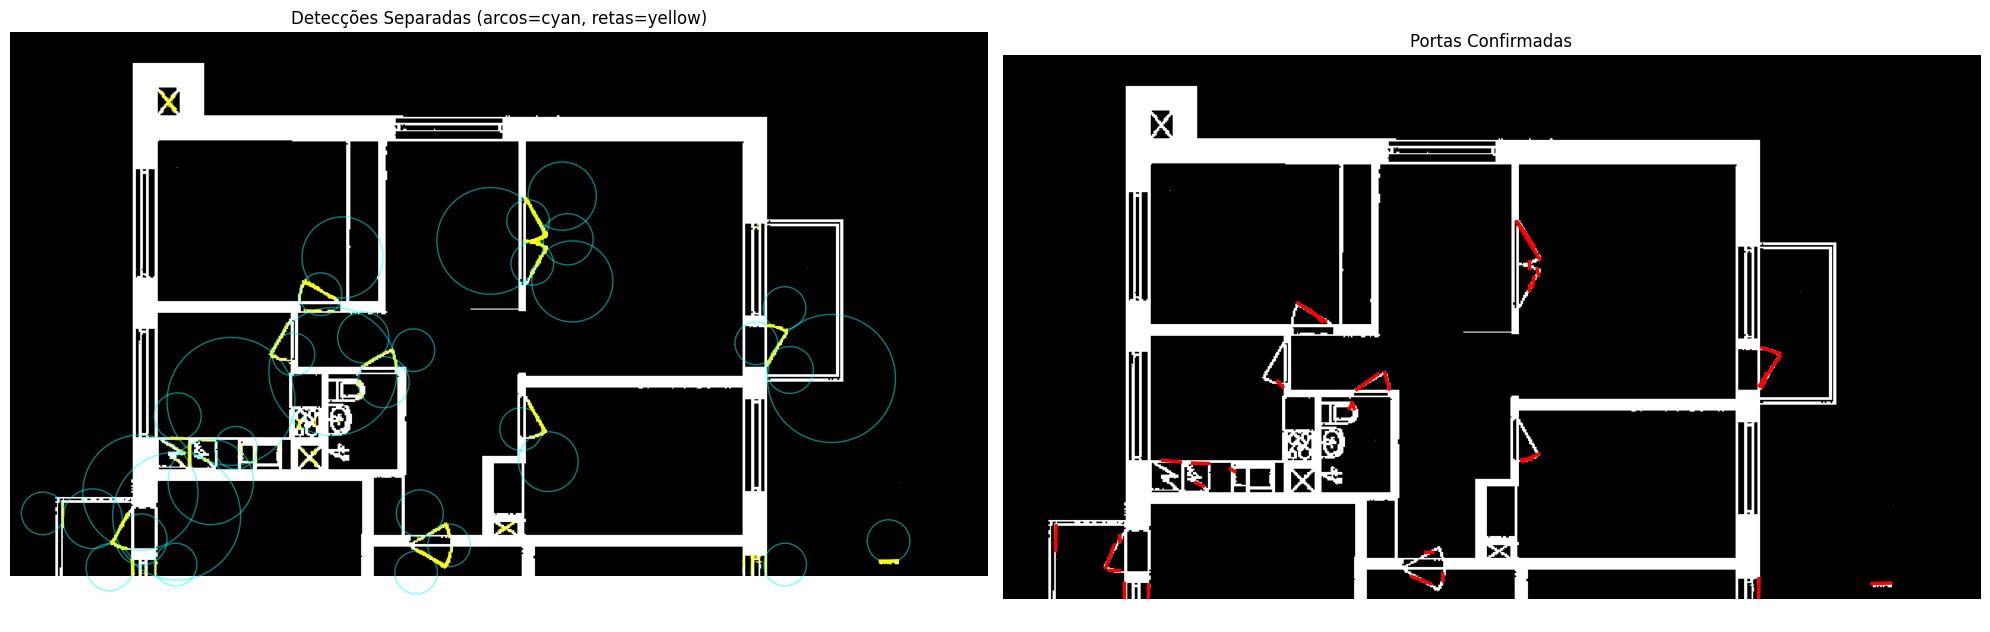

In [46]:
# =============================================================================
# Execução — Validação cruzada e visualização
# =============================================================================
candidatos_para_cruzamento = [
    (cy, cx, r, 1.0)  # score=1.0 pois já foram validados
    for (cy, cx, r, theta1, theta2) in lista_portas_validadas
]

portas_confirmadas = validar_portas_arco_e_reta(
    candidatos_para_cruzamento,
    segmentos_detectados,
    imagem_binaria_invertida,
    raio_minimo
)

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Antes: tudo que foi detectado separadamente
ax1.imshow(imagem_binaria_invertida, cmap='gray')
ax1.set_title("Detecções Separadas (arcos=cyan, retas=yellow)")
for y, x, r, s in candidatos_para_cruzamento:
    ax1.add_patch(plt.Circle((x, y), r, edgecolor='cyan', facecolor='none', linewidth=1, alpha=0.5))
for seg in segmentos_detectados:
    if len(seg) == 4:
        (x1, y1), (x2, y2) = seg[0], seg[1]
        ax1.plot([x1, x2], [y1, y2], color='yellow', linewidth=1, alpha=0.5)
ax1.axis('off')

# Depois: só portas confirmadas
ax2.imshow(imagem_binaria_invertida, cmap='gray')
ax2.set_title(f"Portas Confirmadas")
marcar_portas(ax2, portas_confirmadas)
ax2.axis('off')

plt.tight_layout()
plt.show()

---
## Visualização Final — Marcação de Elementos Estruturais
---
Exibe a planta baixa com os elementos detectados marcados por retângulos coloridos:
- 🟩 **Verde:** Paredes
- 🟥 **Vermelho:** Portas
- 🟨 **Amarelo:** Janelas

Pixels de borda (Sobel): 25375


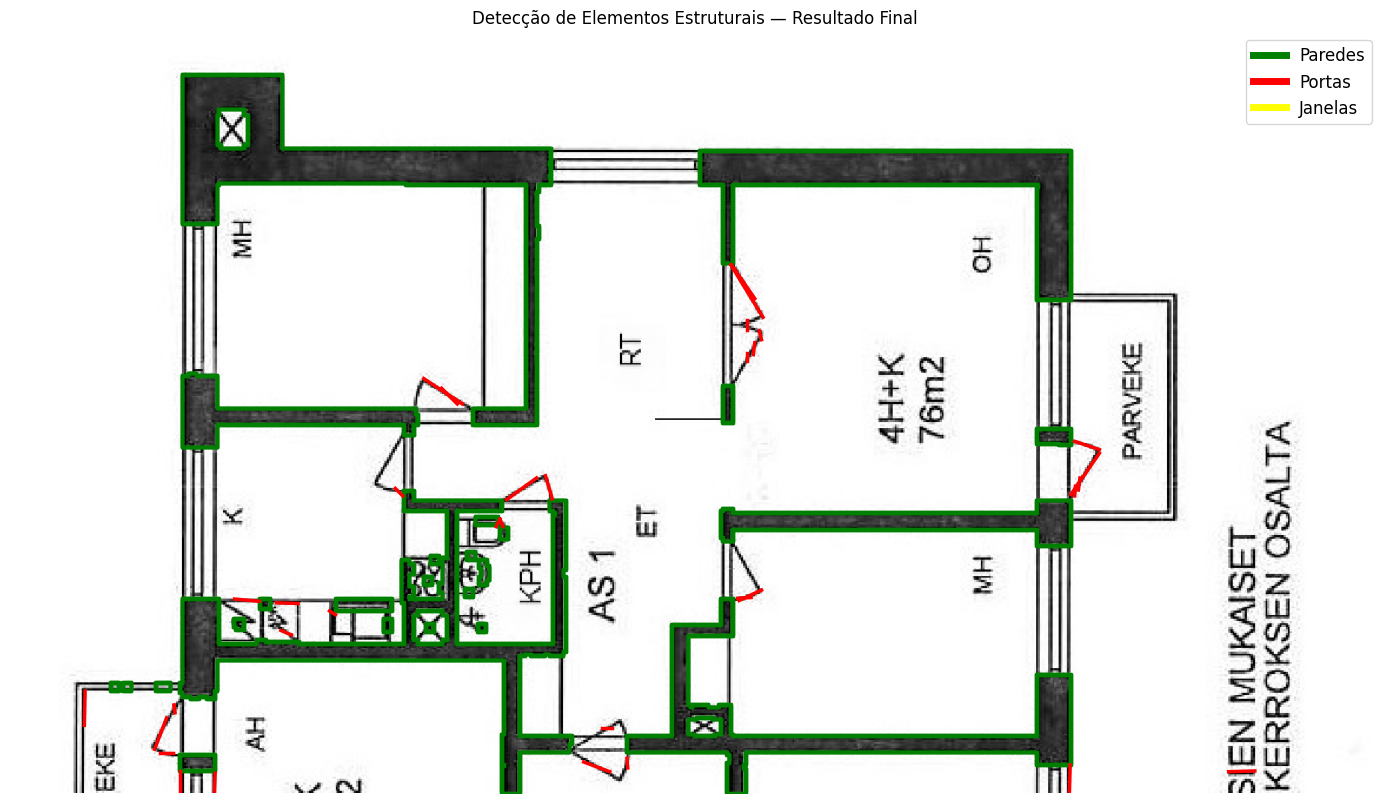

In [48]:
# =============================================================================
# Visualização final com todos os elementos marcados
# =============================================================================
fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(imagem_original, cmap='gray')
ax.set_title("Detecção de Elementos Estruturais — Resultado Final")

# Marca paredes (verde via Sobel)
n_paredes = marcar_paredes_sobel(ax, imagem_paredes)

# Marca portas confirmadas (vermelho — validação cruzada arco + reta)
n_portas = marcar_portas(ax, portas_confirmadas)

# Marca janelas (amarelo) — lista vazia por enquanto
lista_janelas_detectadas = []
# n_janelas = marcar_janelas(ax, lista_janelas_detectadas)

# Legenda
from matplotlib.lines import Line2D
legenda = [
    Line2D([0], [0], color='green', linewidth=5, label='Paredes'),
    Line2D([0], [0], color='red', linewidth=5, label='Portas'),
    Line2D([0], [0], color='yellow', linewidth=5, label='Janelas'),
]
ax.legend(handles=legenda, loc='upper right', fontsize=12)

plt.axis('off')
plt.tight_layout()
plt.show()

---
## CÓDIGO MORTO - Dectação de Portas Ruim
---
## Operações Morfológicas: Hit-or-Miss, Afinamento e Poda

Essas operações são a base para extrair o "esqueleto" das paredes.

- **Hit-or-Miss:** Detecta padrões específicos verificando simultaneamente  
  onde DEVE haver pixels (hit) e onde NÃO DEVE haver (miss).
- **Afinamento:** Remove iterativamente pixels das bordas das paredes,  
  preservando a conectividade, até obter linhas de 1 pixel de largura (esqueleto).
- **Poda:** Remove pequenas ramificações indesejadas do esqueleto.

In [ ]:
# =============================================================================
# Hit-or-Miss: detecção de padrões binários
# =============================================================================
def hit_or_miss(imagem, elemento_hit, elemento_miss):
    """
    Transformada Hit-or-Miss: encontra posições onde o padrão ocorre.

    Funciona em duas etapas simultâneas:
    1. Erode a imagem com 'elemento_hit'     → encontra onde há pixels brancos no padrão
    2. Erode o COMPLEMENTO com 'elemento_miss' → encontra onde há pixels pretos no padrão
    3. Interseção das duas → posições onde o padrão completo existe

    Parâmetros:
        imagem: Imagem binária (0 e 1)
        elemento_hit: Kernel que deve casar com pixels 1 (foreground)
        elemento_miss: Kernel que deve casar com pixels 0 (background)

    Retorna:
        Imagem binária com 1 apenas onde o padrão foi encontrado
    """
    acerto_foreground = binary_erosion(imagem, elemento_hit)
    acerto_background = binary_erosion(1 - imagem, elemento_miss)
    return acerto_foreground * acerto_background

In [ ]:
# =============================================================================
# Afinamento morfológico iterativo
# =============================================================================
def afinamento(imagem, kernels, iteracoes=1):
    """
    Afinamento (thinning): reduz objetos a linhas de 1 pixel preservando topologia.

    Em cada iteração, aplica 8 kernels rotacionados (um para cada direção)
    e remove os pixels detectados usando XOR (subtração lógica).

    O processo é repetido 'iteracoes' vezes até convergir no esqueleto.

    Parâmetros:
        imagem: Imagem binária
        kernels: Lista de pares (hit, miss) — 8 rotações
        iteracoes: Quantas passadas completas pelos 8 kernels
    """
    resultado = imagem.copy()
    for _ in range(iteracoes):
        for elemento_hit, elemento_miss in kernels:
            pixels_a_remover = hit_or_miss(resultado, elemento_hit, elemento_miss)
            resultado = resultado ^ pixels_a_remover.astype(np.uint8)  # XOR = remove
    return resultado

In [ ]:
# =============================================================================
# Poda morfológica (remoção de ramificações)
# =============================================================================
def poda(imagem, kernels, iteracoes=1):
    """
    Poda (pruning): remove pequenas ramificações do esqueleto.

    Idêntica ao afinamento em implementação, mas usa kernels diferentes
    que detectam "pontas soltas" (pixels com apenas 1 vizinho conectado).

    Parâmetros:
        imagem: Esqueleto binário
        kernels: Lista de pares (hit, miss) para detecção de pontas
        iteracoes: Quantas passadas de poda aplicar
    """
    resultado = imagem.copy()
    for _ in range(iteracoes):
        for elemento_hit, elemento_miss in kernels:
            pixels_a_remover = hit_or_miss(resultado, elemento_hit, elemento_miss)
            resultado = resultado ^ pixels_a_remover.astype(np.uint8)
    return resultado

In [ ]:
# =============================================================================
# Kernels de afinamento (8 direções de borda)
# =============================================================================
# Cada par (hit, miss) detecta pixels removíveis em uma direção específica.
# A rotação completa (8 pares) garante afinamento uniforme em todas as direções.

kernels_afinamento = [
    # Direção 1: Borda superior
    (np.array([[0, 0, 0],
               [0, 1, 0],
               [1, 1, 1]], dtype=np.uint8),
     np.array([[1, 1, 1],
               [0, 0, 0],
               [0, 0, 0]], dtype=np.uint8)),

    # Direção 2: Diagonal superior-direita
    (np.array([[0, 0, 0],
               [1, 1, 0],
               [1, 1, 0]], dtype=np.uint8),
     np.array([[0, 1, 1],
               [0, 0, 1],
               [0, 0, 0]], dtype=np.uint8)),

    # Direção 3: Borda direita
    (np.array([[1, 0, 0],
               [1, 1, 0],
               [1, 0, 0]], dtype=np.uint8),
     np.array([[0, 0, 1],
               [0, 0, 1],
               [0, 0, 1]], dtype=np.uint8)),

    # Direção 4: Diagonal inferior-direita
    (np.array([[1, 1, 0],
               [1, 1, 0],
               [0, 0, 0]], dtype=np.uint8),
     np.array([[0, 0, 0],
               [0, 0, 1],
               [0, 1, 1]], dtype=np.uint8)),

    # Direção 5: Borda inferior
    (np.array([[1, 1, 1],
               [0, 1, 0],
               [0, 0, 0]], dtype=np.uint8),
     np.array([[0, 0, 0],
               [0, 0, 0],
               [1, 1, 1]], dtype=np.uint8)),

    # Direção 6: Diagonal inferior-esquerda
    (np.array([[0, 1, 1],
               [0, 1, 1],
               [0, 0, 0]], dtype=np.uint8),
     np.array([[0, 0, 0],
               [1, 0, 0],
               [1, 1, 0]], dtype=np.uint8)),

    # Direção 7: Borda esquerda
    (np.array([[0, 0, 1],
               [0, 1, 1],
               [0, 0, 1]], dtype=np.uint8),
     np.array([[1, 0, 0],
               [1, 0, 0],
               [1, 0, 0]], dtype=np.uint8)),

    # Direção 8: Diagonal superior-esquerda
    (np.array([[0, 0, 0],
               [0, 1, 1],
               [0, 1, 1]], dtype=np.uint8),
     np.array([[1, 1, 0],
               [1, 0, 0],
               [0, 0, 0]], dtype=np.uint8))
]

In [ ]:
# =============================================================================
# Kernels de poda (4 direções de ponta)
# =============================================================================
# Detectam pixels que são "pontas soltas" — extremidades de ramificações
# que sobram após o afinamento e que devem ser removidas.

kernels_poda = [
    # Ponta à direita (pixel isolado com vizinhos apenas à esquerda)
    (np.array([[0, 0, 0],
               [0, 1, 0],
               [0, 0, 0]], dtype=np.uint8),
     np.array([[1, 1, 1],
               [0, 0, 1],
               [1, 1, 1]], dtype=np.uint8)),

    # Ponta à esquerda
    (np.array([[0, 0, 0],
               [0, 1, 0],
               [0, 0, 0]], dtype=np.uint8),
     np.array([[1, 1, 1],
               [1, 0, 0],
               [1, 1, 1]], dtype=np.uint8)),

    # Ponta superior
    (np.array([[0, 0, 0],
               [0, 1, 0],
               [0, 0, 0]], dtype=np.uint8),
     np.array([[1, 0, 1],
               [1, 0, 1],
               [1, 1, 1]], dtype=np.uint8)),

    # Ponta inferior
    (np.array([[0, 0, 0],
               [0, 1, 0],
               [0, 0, 0]], dtype=np.uint8),
     np.array([[1, 1, 1],
               [1, 0, 1],
               [1, 0, 1]], dtype=np.uint8))
]

In [ ]:
# =============================================================================
# Afinamento das paredes (esqueletização)
# =============================================================================
# Reduz as paredes grossas a linhas de 1 pixel de largura.
# 100 iterações garantem convergência completa para imagens típicas.
imagem_sem_portas_esqueleto = afinamento(imagem_sem_portas, kernels_afinamento, iteracoes=100)

In [ ]:
# =============================================================================
# Visualização: Paredes Afinadas
# =============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

ax1.imshow(imagem_sem_portas, cmap='gray')
ax1.set_title("Imagem Original Binaria e Invertida")
ax1.axis('off')

ax2.imshow(imagem_sem_portas_esqueleto, cmap='gray')
ax2.set_title("Imagem Fechada (Paredes + Detalhes)")
ax2.axis('off')

plt.tight_layout()
plt.show()

### Separação de Junções/Dobras e Linhas Retas

O esqueleto das paredes contém tanto linhas retas (trechos de parede) quanto  
pontos de junção (onde paredes se encontram — "dobras" ou "cantos").

**Estratégia:** Usar abertura morfológica com kernels lineares (horizontal e vertical)  
para detectar apenas as linhas retas maiores que `tamanho_minimo` pixels.  
Subtraindo-as do esqueleto, restam apenas as dobras/junções.

In [ ]:
# =============================================================================
# Execução: extrair dobras do esqueleto
# =============================================================================
tamanho_minimo_reta = int(0.01 * min(imagem_original.shape))
print(f"Tamanho mínimo para reta: {tamanho_minimo_reta} pixels")

imagem_dobras, imagem_retas_removidas = remover_linhas_retas(
    imagem_sem_portas, tamanho_minimo_reta
)

In [ ]:
# =============================================================================
# Visualização: esqueleto → retas + dobras
# =============================================================================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.imshow(imagem_sem_portas_esqueleto, cmap='gray')
ax1.set_title("1. Esqueleto Completo")
ax1.axis('off')

ax2.imshow(imagem_retas_removidas, cmap='gray')
ax2.set_title("2. Linhas Retas Removidas")
ax2.axis('off')

ax3.imshow(imagem_dobras, cmap='gray')
ax3.set_title("3. Dobras/Junções Restantes")
ax3.axis('off')

plt.tight_layout()
plt.show()

### Detecção de Portas — Transformada de Hough Circular Adaptada

A ideia central é tratar cada pixel do esqueleto da parede como um possível  
**centro de dobradiça** de porta. Para cada candidato, testamos vários raios  
e verificamos se existe um arco correspondente na imagem sem paredes.

**Analogia do compasso:**
- Ponta seca (centro) = pixel na parede (dobradiça)
- Grafite (perímetro) = arco de porta na imagem de detalhes
- Se o grafite encontrar pixels brancos suficientes, há um arco de porta

**Filtragem:** Após a detecção bruta, removemos duplicatas mantendo  
o candidato com melhor score em cada vizinhança.

In [ ]:
# =============================================================================
# CÉLULA 22 — Transformada de Hough Circular Adaptada (busca de arcos de porta)
# =============================================================================
def transformada_de_hough_circular_adaptada(img_esqueleto, img_arcos, raios_teste, limiar_cobertura=0.05):
    """
    Busca arcos de porta usando uma abordagem inspirada na Transformada de Hough Circular.

    Para cada pixel do esqueleto da parede (possível dobradiça), testa se existe
    um arco de porta (semicírculo) na imagem de detalhes.

    Funcionamento:
    1. Percorre os pixels brancos do esqueleto (candidatos a centro/dobradiça)
    2. Para cada candidato, gera o perímetro de um círculo com raio R
    3. Conta quantos pixels desse perímetro existem na imagem de arcos
    4. Se a cobertura estiver entre limiar_cobertura e 50%, é um arco de porta
       (uma porta de 90° corresponde a ~25% de um círculo completo)

    Parâmetros:
        img_esqueleto: Esqueleto das paredes (pontos candidatos a centro)
        img_arcos: Imagem sem paredes (onde esperamos encontrar arcos)
        raios_teste: range() de raios a testar em pixels
        limiar_cobertura: Fração mínima do perímetro que deve casar (default: 5%)

    Retorna:
        Lista de tuplas (y_centro, x_centro, raio, score)
    """
    altura, largura = img_esqueleto.shape
    portas_encontradas = []

    # Obtém coordenadas de todos os pixels do esqueleto
    y_esqueleto, x_esqueleto = np.where(img_esqueleto > 0)
    print(f"Verificando {len(x_esqueleto)} pontos do esqueleto...")

    # Passo de amostragem (verifica 1 a cada 'passo' pixels para otimização)
    passo = 2

    for i in range(0, len(x_esqueleto), passo):
        centro_x, centro_y = x_esqueleto[i], y_esqueleto[i]

        for raio in raios_teste:
            # circle_perimeter() gera as coordenadas (linha, coluna) do
            # perímetro discretizado de um círculo com centro e raio dados
            rr, cc = circle_perimeter(centro_y, centro_x, raio, shape=(altura, largura))

            if len(rr) == 0:
                continue

            # Conta quantos pixels do perímetro teórico existem na imagem de arcos
            pixels_coincidentes = np.sum(img_arcos[rr, cc])
            total_perimetro = len(rr)
            score = pixels_coincidentes / total_perimetro

            # Aceita se a cobertura indica um arco parcial (porta)
            # Score > 0.5 sugere objeto circular completo (mesa, ruído) → rejeita
            if limiar_cobertura <= score <= 0.5:
                portas_encontradas.append((centro_y, centro_x, raio, score))

                # Se score alto, não precisa testar outros raios para este ponto
                if score > 0.20:
                    break

    return portas_encontradas

---
## CÓDIGO MORTO (TENTATIVA RUIM DE MARCAÇÃO DA PLANTA)

In [ ]:
# ======= CÓDIGO MORTO (TENTATIVA RUIM DE MARCAÇÃO) =======
def marcar_paredes(ax, img_retas_removidas, img_paredes):
    """
    Marca o perímetro das paredes com pixels verdes.

    Para cada pixel do esqueleto reto (img_retas_removidas == 1), caminha nas
    4 direções cardeais sobre img_paredes até encontrar um pixel 0 (borda).
    Esses pixels de borda formam o contorno verde da parede.

    Parâmetros:
        ax: Eixo do matplotlib para desenho
        img_retas_removidas: Esqueleto das paredes (só as retas, sem dobras)
        img_paredes: Paredes grossas (usada para encontrar onde a parede termina)
    """
    altura, largura = img_paredes.shape

    # Imagem RGB para pintar os pixels de borda em verde
    # Inicializa com a imagem de paredes em escala de cinza convertida para RGB
    mascara_borda = np.zeros((altura, largura), dtype=bool)

    # Direções: norte (-1,0), sul (+1,0), leste (0,+1), oeste (0,-1)
    direcoes = [(-1, 0), (1, 0), (0, 1), (0, -1)]

    # Percorre cada pixel do esqueleto reto
    ys, xs = np.where(img_retas_removidas > 0)

    for idx in range(len(ys)):
        i, j = ys[idx], xs[idx]

        for di, dj in direcoes:
            m = 1
            while True:
                ni = i + di * m
                nj = j + dj * m

                # Saiu da imagem → marca a borda no pixel anterior
                if ni < 0 or ni >= altura or nj < 0 or nj >= largura:
                    ni_borda = i + di * (m - 1)
                    nj_borda = j + dj * (m - 1)
                    if 0 <= ni_borda < altura and 0 <= nj_borda < largura:
                        mascara_borda[ni_borda, nj_borda] = True
                    break

                # Chegou em pixel 0 na imagem de paredes → é a borda
                if img_paredes[ni, nj] == 0:
                    mascara_borda[ni, nj] = True
                    break

                m += 1

    # Desenha os pixels de borda como pontos verdes sobre o eixo
    bordas_y, bordas_x = np.where(mascara_borda)

    # Plota de uma vez só (muito mais rápido que ponto a ponto)
    ax.plot(bordas_x, bordas_y, 's', color='green', markersize=5, alpha=0.8)

    n_paredes = len(bordas_y)
    print(f"Pixels de borda de parede marcados: {n_paredes}")
    return n_paredes

def marcar_portas(ax, lista_portas):
  """
  Desenha retângulos vermelhos ao redor de cada porta validada.

  Cada porta é definida por (cy, cx, raio, theta1, theta2).
  O retângulo é calculado a partir do centro e do raio.
  """
  for (cy, cx, raio, theta1, theta2) in lista_portas:
      # O retângulo envolve a área do arco (aproximação quadrada)
      retangulo = Rectangle(
          (cx - raio, cy - raio), 2 * raio, 2 * raio,
          linewidth=2, edgecolor='red', facecolor='none', label='Porta'
      )
      ax.add_patch(retangulo)

  return len(lista_portas)
# ======= CÓDIGO MORTO (TENTATIVA RUIM DE MARCAÇÃO) =======

---
## CÓDIGO MORTO (TENTATIVA RUIM DE MARCAÇÃO DE JANELA)
Estratégia:
*   Usar a imagem_sem_paredes como entrada
*   Implementar a Transformada de Hough para Linhas manualmente
*   Detectar conjuntos de 1, 2 ou 3 linhas paralelas entre si Validar se essas linhas estão posicionadas entre duas paredes
*   Classificar como janela se os critérios forem atendidos


In [ ]:
def janelas_afinamento_skeletonize(bin01):
    """
    Converte binária 0/1 para esqueleto 1px usando skeletonize.
    Entrada: bin01 (0/1 uint8/bool)
    Saída:   0/1 uint8
    """
    sk = skeletonize(bin01.astype(bool))
    return sk.astype(np.uint8)


def janelas_conectar_quebras_direcional(bin01, orientacao="h", k=9, iteracoes=1):
    """
    bin01: imagem binária 0/1 (uint8 ou bool)

    orientacao:
      - "h": conecta quebras só na horizontal  (kernel 1 x k)
      - "v": conecta quebras só na vertical    (kernel k x 1)
    """
    if orientacao == "h":
        estrutura = np.ones((1, k), dtype=np.uint8)
    else:
        estrutura = np.ones((k, 1), dtype=np.uint8)

    out = bin01.astype(bool)
    for _ in range(iteracoes):
        out = binary_closing(out, structure=estrutura)

    return out.astype(np.uint8)

def janelas_segmento_por_componente(coords_yx):
    """
    coords_yx: Nx2 (y,x) dos pixels do componente
    Retorna dict com:
      - seg: (x1,y1,x2,y2)
      - dir: (vx,vy) unitário
      - normal: (a,b,c) de ax + by + c = 0  (normal unitária)
      - angle: angulo da reta normalizado em [-90, 90)
      - length: comprimento do segmento
    """
    pts = coords_yx.astype(np.float32)
    if pts.shape[0] < 10:
        return None

    # coords vêm em (y,x) -> converter pra (x,y)
    xy = np.stack([pts[:, 1], pts[:, 0]], axis=1)
    mean = xy.mean(axis=0)
    centered = xy - mean

    cov = np.cov(centered.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    v = eigvecs[:, 1]  # direção principal (maior autovalor)

    vx, vy = float(v[0]), float(v[1])
    nrm = math.hypot(vx, vy)
    if nrm < 1e-6:
        return None
    vx, vy = vx / nrm, vy / nrm

    # projeta pontos na direção principal -> limites do segmento
    proj = centered @ np.array([vx, vy], dtype=np.float32)
    tmin, tmax = float(proj.min()), float(proj.max())

    p1 = mean + tmin * np.array([vx, vy], dtype=np.float32)
    p2 = mean + tmax * np.array([vx, vy], dtype=np.float32)

    x1, y1 = int(round(p1[0])), int(round(p1[1]))
    x2, y2 = int(round(p2[0])), int(round(p2[1]))

    length = math.hypot(x2 - x1, y2 - y1)

    # ângulo em graus, normalizado para agrupar paralelas
    ang = math.degrees(math.atan2((y2 - y1), (x2 - x1)))
    while ang < -90:
        ang += 180
    while ang >= 90:
        ang -= 180

    # normal unitária (a,b) e c (ax + by + c = 0)
    a, b = vy, -vx
    c = -(a * mean[0] + b * mean[1])

    return {
        "seg": (x1, y1, x2, y2),
        "dir": (vx, vy),
        "normal": (a, b, c),
        "angle": ang,
        "length": length
    }


def janelas_extrair_linhas_de_componentes(bin01, min_area=30, min_len=25):
    """
    bin01: 0/1
    Retorna lista de dicts "linhas" (segmentos) extraídos via PCA.
    """
    rotulos = label(bin01.astype(bool), connectivity=2)
    props = regionprops(rotulos)

    infos = []
    for r in props:
        if r.area < min_area:
            continue
        info = janelas_segmento_por_componente(r.coords)
        if info is None:
            continue
        if info["length"] < min_len:
            continue
        infos.append(info)
    return infos


def janelas_agrupar_por_angulo(infos, tol=3.0):
    items = sorted(infos, key=lambda d: d["angle"])
    grupos, cur = [], []
    for it in items:
        if not cur:
            cur = [it]
        else:
            if abs(it["angle"] - cur[-1]["angle"]) <= tol:
                cur.append(it)
            else:
                grupos.append(cur)
                cur = [it]
    if cur:
        grupos.append(cur)
    return grupos


def janelas_alinhar_normais(normais):
    """
    Garante que todas as normais apontem no "mesmo sentido" para ordenar por c.
    """
    a0, b0, _ = normais[0]
    fixed = [normais[0]]
    for a, b, c in normais[1:]:
        if (a * a0 + b * b0) < 0:
            a, b, c = -a, -b, -c
        fixed.append((a, b, c))
    return fixed


def janelas_encontrar_quads_4_linhas(
    infos,
    angle_tol_deg=3.0,
    dmin=3, dmax=16,
    spacing_tol=3.0,
    min_overlap=20
):
    """
    Procura conjuntos de 4 linhas paralelas:
    - ângulos próximos
    - normais compatíveis
    - espaçamentos (d1,d2,d3) dentro de [dmin,dmax] e similares (spacing_tol)
    - sobreposição mínima ao longo da direção da linha (min_overlap)
    """
    grupos = janelas_agrupar_por_angulo(infos, tol=angle_tol_deg)
    quads = []

    for g in grupos:
        if len(g) < 4:
            continue

        for comb in combinations(g, 4):
            normais = [it["normal"] for it in comb]
            fixed = janelas_alinhar_normais(normais)

            # (a,b) devem ser praticamente iguais
            a0, b0, _ = fixed[0]
            ok = True
            for a, b, _ in fixed[1:]:
                if abs(a - a0) > 1e-2 or abs(b - b0) > 1e-2:
                    ok = False
                    break
            if not ok:
                continue

            # ordena por c
            idx = sorted(range(4), key=lambda i: fixed[i][2])
            cs = [fixed[i][2] for i in idx]

            d1 = abs(cs[1] - cs[0])
            d2 = abs(cs[2] - cs[1])
            d3 = abs(cs[3] - cs[2])

            if not (dmin <= d1 <= dmax and dmin <= d2 <= dmax and dmin <= d3 <= dmax):
                continue
            if max(d1, d2, d3) - min(d1, d2, d3) > spacing_tol:
                continue

            # sobreposição ao longo da direção da linha
            vx, vy = comb[0]["dir"]
            v = np.array([vx, vy], dtype=np.float32)

            intervals = []
            for it in comb:
                x1, y1, x2, y2 = it["seg"]
                p1 = np.array([x1, y1], dtype=np.float32)
                p2 = np.array([x2, y2], dtype=np.float32)
                t1 = float(p1 @ v)
                t2 = float(p2 @ v)
                intervals.append((min(t1, t2), max(t1, t2)))

            common_min = max(iv[0] for iv in intervals)
            common_max = min(iv[1] for iv in intervals)
            common = max(0.0, common_max - common_min)

            if common < min_overlap:
                continue

            ordered = [comb[i] for i in idx]
            quads.append({"lines": ordered})

    return quads

def janelas_desenhar_segmento_em_mascara(mask, seg, thickness=2):
    """
    mask: 0/1 uint8
    seg: (x1,y1,x2,y2)
    """
    x1, y1, x2, y2 = seg
    rr, cc = line(y1, x1, y2, x2)  # (y,x)
    rr = np.clip(rr, 0, mask.shape[0]-1)
    cc = np.clip(cc, 0, mask.shape[1]-1)
    mask[rr, cc] = 1

    # espessura simples (pinta vizinhança quadrada)
    if thickness > 1:
        r = thickness // 2
        for dy in range(-r, r+1):
            for dx in range(-r, r+1):
                r2 = np.clip(rr + dy, 0, mask.shape[0]-1)
                c2 = np.clip(cc + dx, 0, mask.shape[1]-1)
                mask[r2, c2] = 1


def janelas_overlay_amarelo(base_gray_01, janela_mask_01):
    """
    base_gray_01: 0/1 (uint8)
    janela_mask_01: 0/1
    retorna RGB uint8 com janelas em amarelo.
    """
    base = (base_gray_01.astype(np.uint8) * 255)
    rgb = np.dstack([base, base, base])  # grayscale -> RGB

    y = janela_mask_01.astype(bool)
    rgb[y, 0] = 255
    rgb[y, 1] = 255
    rgb[y, 2] = 0
    return rgb


def marcar_janelas(ax, quads, cor='yellow', linewidth=2.5, alpha=0.9):
    """
    Desenha todas as linhas das janelas (quads) no eixo ax.
    Retorna o número de janelas (quads) desenhadas.
    """
    for q in quads:
        for it in q["lines"]:
            x1, y1, x2, y2 = it["seg"]
            ax.plot([x1, x2], [y1, y2], color=cor, linewidth=linewidth, alpha=alpha)
    return len(quads)



img_in = (imagem_portas_sem_retas > 0).astype(np.uint8)

img_in_thin = janelas_afinamento_skeletonize(img_in)

k_morf = 9
bin_h = janelas_conectar_quebras_direcional(img_in_thin, orientacao="h", k=k_morf, iteracoes=1)
bin_v = janelas_conectar_quebras_direcional(img_in_thin, orientacao="v", k=k_morf, iteracoes=1)

# extrair segmentos
h_infos = janelas_extrair_linhas_de_componentes(bin_h, min_area=20, min_len=20)
v_infos = janelas_extrair_linhas_de_componentes(bin_v, min_area=20, min_len=20)

print("Componentes horizontais:", len(h_infos))
print("Componentes verticais  :", len(v_infos))

# detectar janelas
h_quads = janelas_encontrar_quads_4_linhas(h_infos, angle_tol_deg=3.0, dmin=3, dmax=16, spacing_tol=3.0, min_overlap=20)
v_quads = janelas_encontrar_quads_4_linhas(v_infos, angle_tol_deg=3.0, dmin=3, dmax=16, spacing_tol=3.0, min_overlap=20)

print("Janelas horizontais:", len(h_quads))
print("Janelas verticais  :", len(v_quads))

lista_janelas_detectadas = h_quads + v_quads

imagem_janelas_mask = np.zeros_like(img_in, dtype=np.uint8)

for q in h_quads:
    for it in q["lines"]:
        janelas_desenhar_segmento_em_mascara(imagem_janelas_mask, it["seg"], thickness=2)

for q in v_quads:
    for it in q["lines"]:
        janelas_desenhar_segmento_em_mascara(imagem_janelas_mask, it["seg"], thickness=2)

imagem_janelas_overlay = janelas_overlay_amarelo(img_in, imagem_janelas_mask)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(26, 7))

ax1.imshow(img_in, cmap='gray')
ax1.set_title("Entrada: imagem_portas_sem_retas (0/1)")
ax1.axis('off')

ax2.imshow(img_in_thin, cmap='gray')
ax2.set_title("Afinamento (skeletonize) — 1px")
ax2.axis('off')

ax3.imshow(imagem_janelas_mask, cmap='gray')
ax3.set_title("Máscara de janelas (4 linhas)")
ax3.axis('off')

ax4.imshow(imagem_janelas_overlay)
ax4.set_title("Janelas marcadas em amarelo (overlay)")
ax4.axis('off')

plt.tight_layout()
plt.show()
# ======= CÓDIGO MORTO (TENTATIVA RUIM DE MARCAÇÃO) =======
